# CMPE 255-03, Fall 2024
## Steam CS2 and TF2 Project

**Due Date:** 6:00pm on Nov 20th, 2024

EDA Project for Steam Items in CS2 and TF2

---

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
from scipy.stats import pearsonr


Remove Duplicates from Review Files

In [2]:
# Load the dataset
# data = pd.read_csv('reviews_440.csv')
# data.head()

file = pd.read_csv('reviews_440.csv')

# file.info()

file_cleaned = file.drop_duplicates(subset=['recommendationid', 'steamid'], keep=False)

print(file_cleaned.shape[0])

file_cleaned.to_csv("reviews_440_combined.csv", index=False)

# file_cleaned.info()

# data.info()

1119786


#### 1. Remove Duplicates from CSV Files

In [3]:
file = pd.read_csv('./CS2Reviews/reviews_730_combined.csv')

file.info()

file_cleaned = file.drop_duplicates(subset=['recommendationid', 'steamid'], keep=False)

# print(file_cleaned.shape[0])

file_cleaned.to_csv("./CS2Reviews/reviews_730_combined_2.csv", index=False)


C:\Users\chaoa\AppData\Local\Temp\ipykernel_17464\4061065716.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv('./CS2Reviews/reviews_730_combined.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8367210 entries, 0 to 8367209
Data columns (total 24 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   recommendationid             int64  
 1   gameid                       int64  
 2   steamid                      int64  
 3   num_games_owned              int64  
 4   num_reviews                  int64  
 5   playtime_forever             float64
 6   playtime_last_two_weeks      float64
 7   playtime_at_review           float64
 8   last_played                  float64
 9   language                     object 
 10  review_length                int64  
 11  timestamp_created            int64  
 12  timestamp_updated            int64  
 13  voted_up                     bool   
 14  votes_up                     int64  
 15  votes_funny                  int64  
 16  weighted_vote_score          float64
 17  comment_count                int64  
 18  steam_purchase               bool   
 19  

### Checking files

In [4]:
cv = pd.read_csv('./CS2Reviews/reviews_730_combined_2.csv')

# cv.info()

# Convert `timestamp_created` to datetime
cv['date_created'] = pd.to_datetime(cv['timestamp_created'], unit='s').dt.date

# Calculate the log of review length (adding a small constant to avoid log(0))
cv['log_review_length'] = np.log(cv['review_length'] + 1)

# Calculate weighted `voted_up` by multiplying with `log_review_length`
cv['weighted_voted_up'] = cv['voted_up'] * cv['log_review_length']

# Group by `date_created` and aggregate values
daily_summary = cv.groupby('date_created').agg({
    'recommendationid': 'count',                # Count of reviews per day
    'playtime_forever': 'mean',                 # Average playtime per day
    'votes_up': 'sum',                          # Total votes up per day
    'votes_funny': 'sum',                       # Total funny votes per day
    'log_review_length': 'sum',                 # Total log review length per day for weighting
    'weighted_voted_up': 'sum'                  # Sum of weighted voted_up
}).reset_index()

# Calculate the weighted average of `voted_up` for each day
daily_summary['weighted_avg_voted_up'] = daily_summary['weighted_voted_up'] / daily_summary['log_review_length']

# Rename columns for clarity
daily_summary = daily_summary.rename(columns={
    'recommendationid': 'daily_review_count',
    'playtime_forever': 'avg_playtime_forever',
    'votes_up': 'total_votes_up',
    'votes_funny': 'total_votes_funny'
})

# Display the result
print(daily_summary.head())



C:\Users\chaoa\AppData\Local\Temp\ipykernel_17464\2407533756.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  cv = pd.read_csv('./CS2Reviews/reviews_730_combined_2.csv')


  date_created  daily_review_count  avg_playtime_forever  total_votes_up  \
0   2012-05-12                   1           1860.000000              14   
1   2012-08-14                  22          90829.636364               7   
2   2012-08-15                 161          88661.031056              84   
3   2012-08-16                 112          99909.294643              62   
4   2012-08-17                 122          94592.147541             124   

   total_votes_funny  log_review_length  weighted_voted_up  \
0                  4           3.891820           3.891820   
1                  3          85.736384          59.153218   
2                 32         626.389818         551.980107   
3                  9         425.899897         339.007443   
4                 23         471.490247         395.078785   

   weighted_avg_voted_up  
0               1.000000  
1               0.689943  
2               0.881209  
3               0.795979  
4               0.837936  


#### Removing Duplicate Blobs at the beginning or end of files (situations where requests halted prematurely and overlap occurred)

In [5]:
file_paths = sorted(glob.glob('./CS2Prices/*.csv'))  # Sort if order matters

print(file_paths)

# Start by loading the first file as the initial base
combined_df = pd.read_csv(file_paths[0])

# Iterate over remaining files and combine without duplicates
for file_path in file_paths[1:]:
    # Load the next file
    next_df = pd.read_csv(file_path)
    
    # Remove entries in `next_df` that already exist in `combined_df`
    next_df = next_df[~next_df.set_index(['Item Name', 'Date']).index.isin(combined_df.set_index(['Item Name', 'Date']).index)]
    
    # Concatenate the unique entries to `combined_df`
    combined_df = pd.concat([combined_df, next_df], ignore_index=True)

# Save the final deduplicated result
combined_df.to_csv("./CS2Prices/CombinedCS2Prices.csv", index=False)

['./CS2Prices\\CombinedCS2Prices.csv', './CS2Prices\\CombinedCS2Prices_Dates.csv', './CS2Prices\\CombinedCS2Prices_Dates_Lifetime.csv', './CS2Prices\\steam_730_price_history_1.csv', './CS2Prices\\steam_730_price_history_2.csv', './CS2Prices\\steam_730_price_history_3.csv', './CS2Prices\\steam_730_price_history_4.csv']


In [6]:
df = pd.read_csv('./CS2Prices/CombinedCS2Prices.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15524405 entries, 0 to 15524404
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Item Name      object 
 1   Parent         object 
 2   Date           object 
 3   Price          float64
 4   Volume         int64  
 5   DateTime       float64
 6   Day            float64
 7   Month          float64
 8   Year           float64
 9   Lifespan       float64
 10  Lifespan_Days  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.3+ GB


TF2 Prices

In [7]:
file_paths = ["./TF2Prices/steam_440_price_history_1_31.csv", "./TF2Prices/steam_price_history_tf2_32-103.csv"]

# Start by loading the first file as the initial base
combined_df = pd.read_csv(file_paths[0])

# Iterate over remaining files and combine without duplicates
for file_path in file_paths[1:]:
    # Load the next file
    next_df = pd.read_csv(file_path)
    
    # Remove entries in `next_df` that already exist in `combined_df`
    next_df = next_df[~next_df.set_index(['Item Name', 'Parent', 'Date']).index.isin(combined_df.set_index(['Item Name', 'Parent', 'Date']).index)]
    
    # Concatenate the unique entries to `combined_df`
    combined_df = pd.concat([combined_df, next_df], ignore_index=True)

# Save the final deduplicated result
combined_df.to_csv("./TF2Prices/CombinedTF2Prices.csv", index=False)

In [8]:
# Accounting for items with multiple parents

combined_df = pd.read_csv("./TF2Prices/CombinedTF2Prices.csv")

# # Identify rows with duplicates
# duplicate_groups = combined_df.groupby(['Item Name', 'Date']).filter(lambda x: len(x) > 1)

# print("Combined rows (only those with duplicates):")
# print(duplicate_groups)

# Group by 'Item Name' and 'Date' and aggregate with Parent as a list
combined_df = combined_df.groupby(['Item Name', 'Date'], as_index=False).agg({
    'Parent': lambda x: list(x.unique()),
    'Price': 'first',
    'Volume': 'first'
})

# Filter rows where the 'Parent' list has more than one entry
multiple_parents = combined_df[combined_df['Parent'].apply(len) > 1]

print("Rows with multiple parents:")
print(multiple_parents)

Rows with multiple parents:
                        Item Name                Date  \
0        A Color Similar to Slate  Apr 01 2013 01: +0   
1        A Color Similar to Slate  Apr 01 2014 01: +0   
2        A Color Similar to Slate  Apr 01 2015 01: +0   
3        A Color Similar to Slate  Apr 01 2016 01: +0   
4        A Color Similar to Slate  Apr 01 2017 01: +0   
...                           ...                 ...   
1071332         Zepheniah's Greed  Sep 30 2024 18: +0   
1071333         Zepheniah's Greed  Sep 30 2024 19: +0   
1071334         Zepheniah's Greed  Sep 30 2024 20: +0   
1071335         Zepheniah's Greed  Sep 30 2024 21: +0   
1071336         Zepheniah's Greed  Sep 30 2024 23: +0   

                                                    Parent  Price  Volume  
0        [Mann Co. Supply Crate Series #9, Mann Co. Sup...  0.931      18  
1        [Mann Co. Supply Crate Series #9, Mann Co. Sup...  0.854      12  
2        [Mann Co. Supply Crate Series #9, Mann Co. Sup... 

In [9]:
# Export Combined Datasets
combined_df.to_json('./TF2Prices/CombinedTF2Prices_MultiParents.json', orient='records', lines=True)

#### 2. Feature Engineering

In [10]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices.csv')

tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents.json', orient='records', lines=True)

##### 2.1 DateTime --> Day / Month / Year Columns (Chronological Data)

In [11]:
from datetime import datetime, timedelta

def convert_date_time(date_string):
    # Parse the date and time, ignoring the timezone offset
    dt = datetime.strptime(date_string[:-3], "%b %d %Y %H:")

    # Add the timezone offset
    offset = int(date_string[-2:])
    dt = dt + timedelta(hours=offset)

    return dt

date_string = "Oct 27 2024 09: +0"
converted_dt = convert_date_time(date_string)
print(converted_dt)

2024-10-27 09:00:00


CS2

In [12]:
cs['DateTime'] = cs['Date'].apply(convert_date_time) # ISO 8601 format (YYYY-MM-DD)

cs['Day'] = cs['DateTime'].dt.day
cs['Month'] = cs['DateTime'].dt.month # integer month
cs['Year'] = cs['DateTime'].dt.year

print(cs[['Date', 'Day', 'Month', 'Year', 'DateTime']])

                        Date  Day  Month  Year            DateTime
0         Aug 14 2013 01: +0   14      8  2013 2013-08-14 01:00:00
1         Aug 15 2013 01: +0   15      8  2013 2013-08-15 01:00:00
2         Aug 16 2013 01: +0   16      8  2013 2013-08-16 01:00:00
3         Aug 17 2013 01: +0   17      8  2013 2013-08-17 01:00:00
4         Aug 18 2013 01: +0   18      8  2013 2013-08-18 01:00:00
...                      ...  ...    ...   ...                 ...
15524400  Oct 25 2024 13: +0   25     10  2024 2024-10-25 13:00:00
15524401  Oct 25 2024 17: +0   25     10  2024 2024-10-25 17:00:00
15524402  Oct 26 2024 01: +0   26     10  2024 2024-10-26 01:00:00
15524403  Oct 26 2024 05: +0   26     10  2024 2024-10-26 05:00:00
15524404  Oct 26 2024 11: +0   26     10  2024 2024-10-26 11:00:00

[15524405 rows x 5 columns]


In [13]:
cs.to_csv("./CS2Prices/CombinedCS2Prices_Dates.csv", index=False)

TF2

In [14]:
tf['DateTime'] = tf['Date'].apply(convert_date_time) # ISO 8601 format (YYYY-MM-DD)

tf['Day'] = tf['DateTime'].dt.day
tf['Month'] = tf['DateTime'].dt.month # integer month
tf['Year'] = tf['DateTime'].dt.year

print(tf['DateTime'])

0         2013-04-01 01:00:00
1         2014-04-01 01:00:00
2         2015-04-01 01:00:00
3         2016-04-01 01:00:00
4         2017-04-01 01:00:00
                  ...        
1071332   2024-09-30 18:00:00
1071333   2024-09-30 19:00:00
1071334   2024-09-30 20:00:00
1071335   2024-09-30 21:00:00
1071336   2024-09-30 23:00:00
Name: DateTime, Length: 1071337, dtype: datetime64[ns]


In [15]:
# tf['Iso_Date'] = tf['Iso_Date'].dt.strftime('%Y-%m-%dT%H:%M:%S')
tf.to_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates.json', orient='records', lines=True, date_format='iso')

tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates.json', orient='records', lines=True)

print(tf['DateTime'])

0         2013-04-01 01:00:00
1         2014-04-01 01:00:00
2         2015-04-01 01:00:00
3         2016-04-01 01:00:00
4         2017-04-01 01:00:00
                  ...        
1071332   2024-09-30 18:00:00
1071333   2024-09-30 19:00:00
1071334   2024-09-30 20:00:00
1071335   2024-09-30 21:00:00
1071336   2024-09-30 23:00:00
Name: DateTime, Length: 1071337, dtype: datetime64[ns]


##### 2.2 Lifespan = Current date - first date (Chronological Data)

CS2

In [16]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates.csv')

# cs.info()
# Convert 'Iso_Date' to datetime
cs['DateTime'] = pd.to_datetime(cs['DateTime'])

# Find the first occurrence of each item
first_occurrence = cs.groupby('Item Name')['DateTime'].transform('min')

# Calculate Lifespan by subtracting the first occurrence date from the current row's date
cs['Lifespan'] = cs['DateTime'] - first_occurrence

# Optional: Convert Lifespan to total days
cs['Lifespan_Days'] = cs['Lifespan'].dt.days

# Display the DataFrame
# print(cs)

In [17]:
cs.to_csv("./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv", index=False)

TF2

In [18]:
tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates.json', orient='records', lines=True)

tf['DateTime'] = pd.to_datetime(tf['DateTime'])

print(tf['DateTime'][:5])

# Find the first occurrence of each item
first_occurrence = tf.groupby('Item Name')['DateTime'].transform('min')

print(first_occurrence[:5])

# Calculate Lifespan by subtracting the first occurrence date from the current row's date
tf['Lifespan'] = tf['DateTime'] - first_occurrence

print(tf['Lifespan'][:5])

# Optional: Convert Lifespan to total days
tf['Lifespan_Days'] = tf['Lifespan'].dt.days

# print(tf)

0   2013-04-01 01:00:00
1   2014-04-01 01:00:00
2   2015-04-01 01:00:00
3   2016-04-01 01:00:00
4   2017-04-01 01:00:00
Name: DateTime, dtype: datetime64[ns]
0   2012-12-12 01:00:00
1   2012-12-12 01:00:00
2   2012-12-12 01:00:00
3   2012-12-12 01:00:00
4   2012-12-12 01:00:00
Name: DateTime, dtype: datetime64[ns]
0    110 days
1    475 days
2    840 days
3   1206 days
4   1571 days
Name: Lifespan, dtype: timedelta64[ns]


In [19]:
tf.to_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True, date_format='iso')

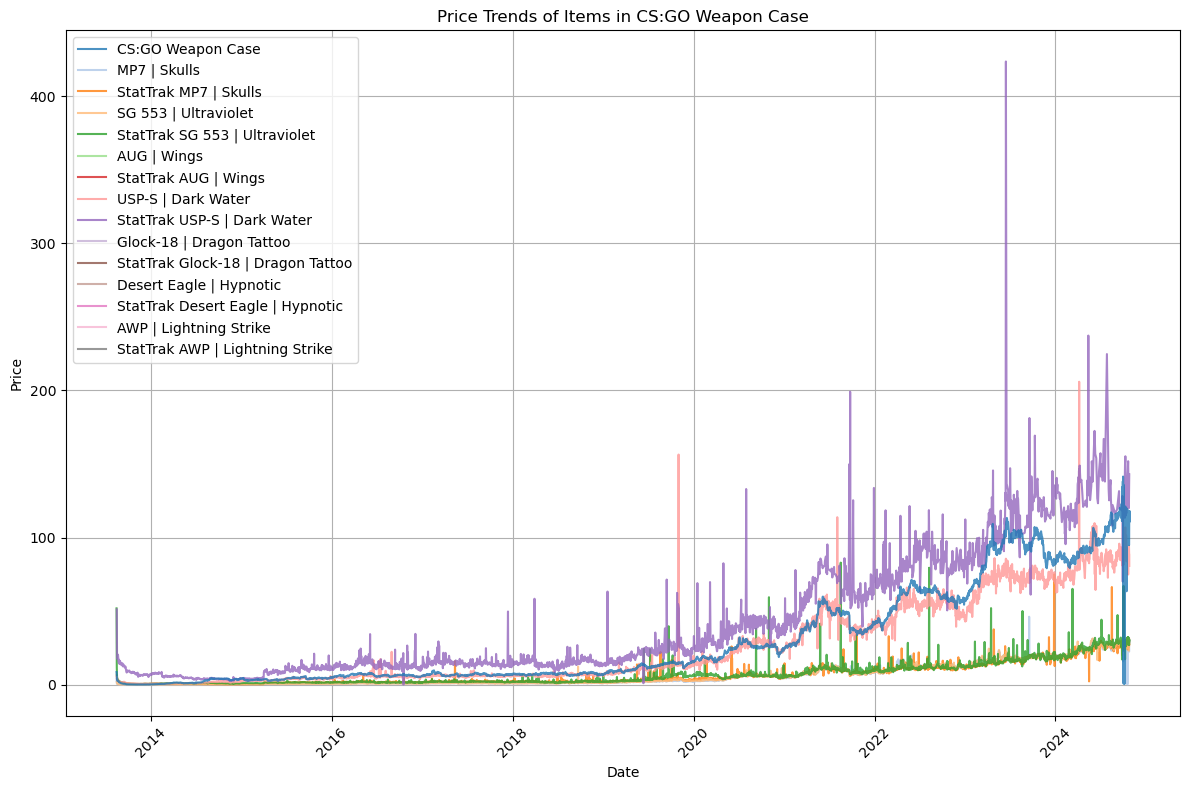

In [20]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv')

family = {'CS:GO Weapon Case': ['MP7 | Skulls', 'SG 553 | Ultraviolet', 'AUG | Wings', 'USP-S | Dark Water', 'Glock-18 | Dragon Tattoo', 'Desert Eagle | Hypnotic', 'AWP | Lightning Strike']}

# Ensure 'DateTime' column is in datetime format
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')

# Set up the plot
plt.figure(figsize=(12, 8))

conditions = ['(Battle-Scarred)', '(Well-Worn)', '(Field-Tested)', '(Minimal Wear)', '(Factory New)']

# Initialize color map
colors = plt.cm.tab20.colors
# Track color index
color_idx = 20

# Loop through each parent and their children in the family dictionary
for parent, children in family.items():
    item_data = cs[cs['Item Name'] == parent]
    # Plot the price over time for each child item
    plt.plot(item_data['DateTime'], item_data['Price'], label=parent, color=colors[color_idx % len(colors)], alpha=0.8, zorder=10)
    color_idx += 1

    for child in children:
        # for condition in conditions[2:3]:
        # Filter the DataFrame for each child item
        item_data = cs[cs['Item Name'] == (child + f' (Field-Tested)')]

        # Plot the price over time for each child item
        plt.plot(item_data['DateTime'], item_data['Price'], label=child, color=colors[color_idx % len(colors)], alpha=0.8)
        color_idx += 1

        # Filter the DataFrame for each child item
        item_data = cs[cs['Item Name'] == ('StatTrak ' + child + f' (Field-Tested)')]

        # Plot the price over time for each child item
        plt.plot(item_data['DateTime'], item_data['Price'], label='StatTrak ' + child, color=colors[color_idx % len(colors)], alpha=0.8)
        color_idx += 1
        

# Customize the plot
plt.title('Price Trends of Items in CS:GO Weapon Case')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')  # Adds a legend to differentiate items
plt.xticks(rotation=45)       # Rotate x-axis dates for readability
plt.grid(True)                # Add grid for easier reading of values

# Show the plot
plt.tight_layout()            # Adjust layout to prevent overlap
plt.show()


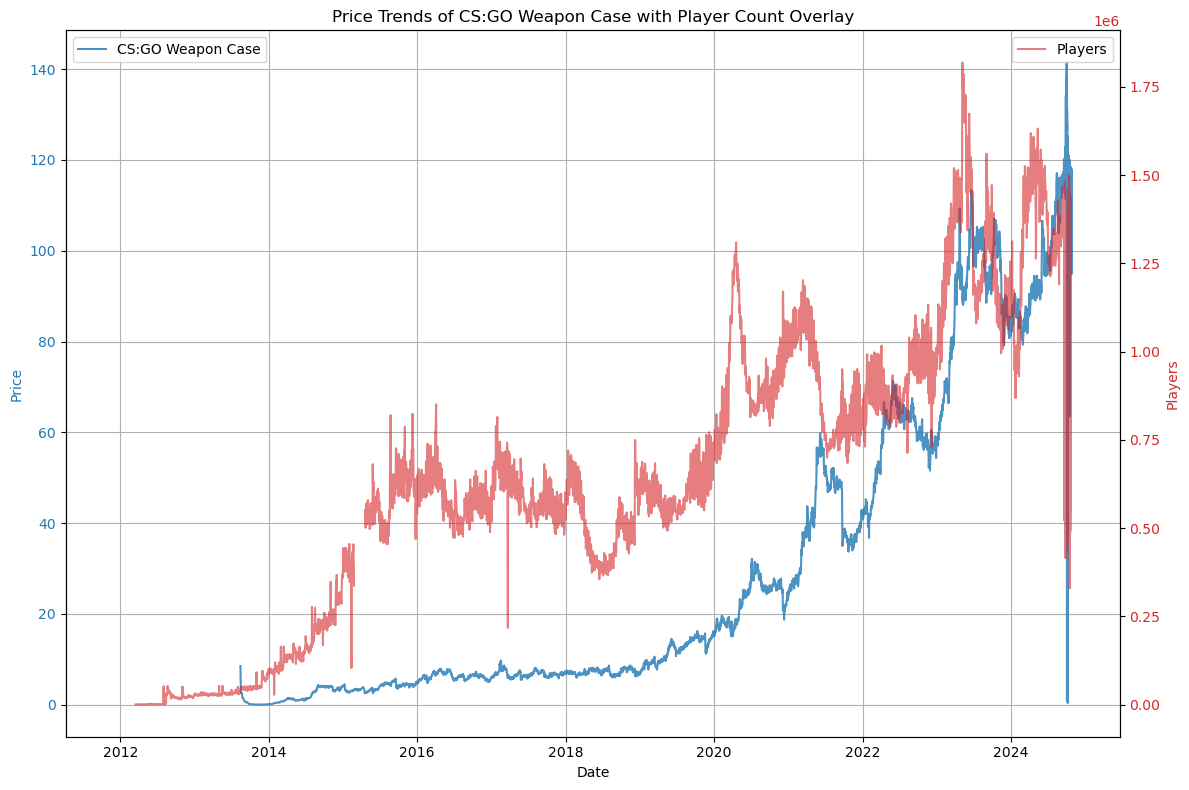

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv')
cs_filtered = pd.read_csv('./PlayerCount/cs2playercount.csv')

# Ensure 'DateTime' columns are in datetime format
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')

# Dictionary for parent items and their children
family = {'CS:GO Weapon Case': ['MP7 | Skulls', 'SG 553 | Ultraviolet', 'AUG | Wings', 'USP-S | Dark Water', 'Glock-18 | Dragon Tattoo', 'Desert Eagle | Hypnotic', 'AWP | Lightning Strike']}

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define color map for different lines
colors = plt.cm.tab20.colors
color_idx = 20

# Plot the parent item price trend over time on the primary y-axis
for parent, children in family.items():
    item_data = cs[cs['Item Name'] == parent]
    
    # Group by date if needed and plot
    item_data_agg = item_data.groupby('DateTime')['Price'].mean().reset_index()
    ax1.plot(item_data_agg['DateTime'], item_data_agg['Price'], label=parent, color=colors[color_idx % len(colors)], alpha=0.8, zorder=10)
    color_idx += 1

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()

# Plot player count data on the secondary y-axis
ax2.plot(cs_filtered['DateTime'], cs_filtered['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Price Trends of CS:GO Weapon Case with Player Count Overlay')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

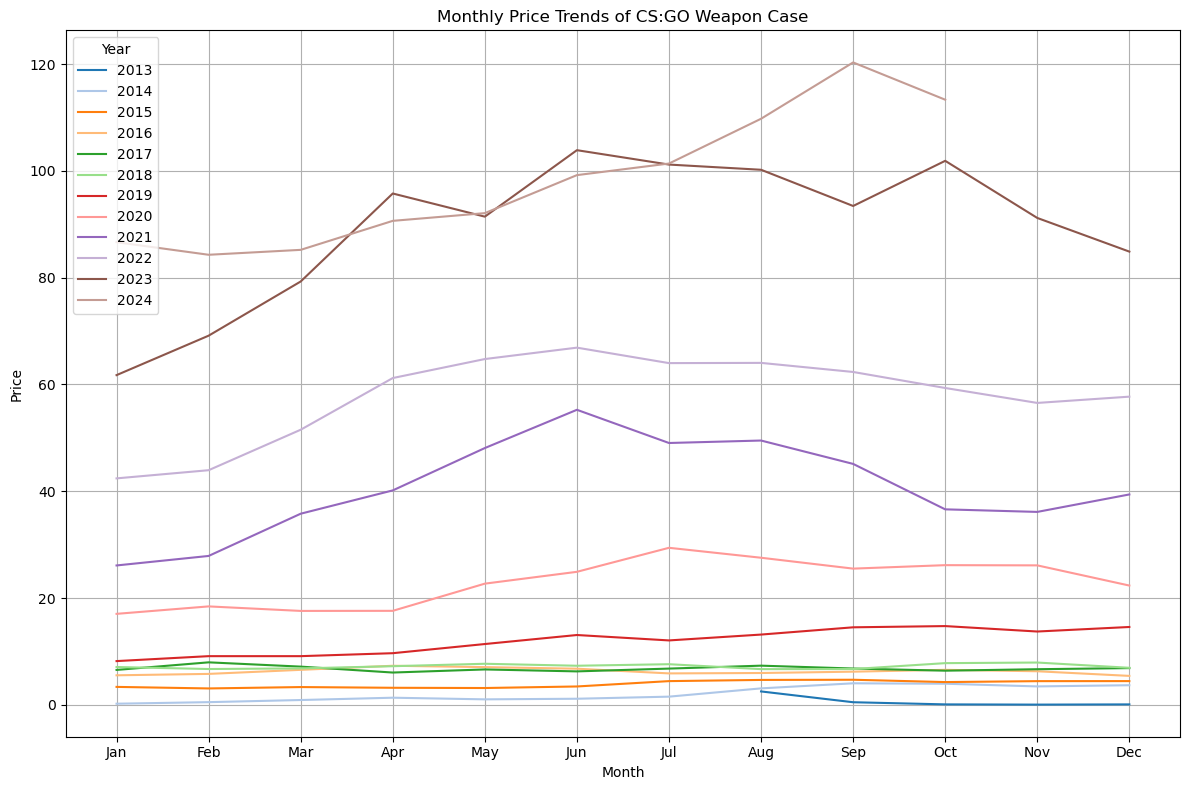

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Load the data
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv')

# Ensure 'DateTime' column is in datetime format
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')

# Dictionary for parent items and their children
family = {'CS:GO Weapon Case': ['MP7 | Skulls', 'SG 553 | Ultraviolet', 'AUG | Wings', 'USP-S | Dark Water', 'Glock-18 | Dragon Tattoo', 'Desert Eagle | Hypnotic', 'AWP | Lightning Strike']}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define color map for different lines
colors = plt.cm.tab20.colors

# Get the parent item
parent = list(family.keys())[0]

# Filter data for the parent item and create a copy
item_data = cs[cs['Item Name'] == parent].copy()

# Extract year and month from DateTime
item_data['Year'] = item_data['DateTime'].dt.year
item_data['Month'] = item_data['DateTime'].dt.month

# Group by Year and Month, and calculate mean price
item_data_agg = item_data.groupby(['Year', 'Month'])['Price'].mean().reset_index()

# Get unique years
years = sorted(item_data_agg['Year'].unique())

# Plot a line for each year
for i, year in enumerate(years):
    year_data = item_data_agg[item_data_agg['Year'] == year]
    ax.plot(year_data['Month'], year_data['Price'], label=str(year), color=colors[i % len(colors)])

# Customize the x-axis
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

# Title and grid for clarity
plt.title(f'Monthly Price Trends of {parent}')
ax.legend(title='Year', loc='upper left')
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

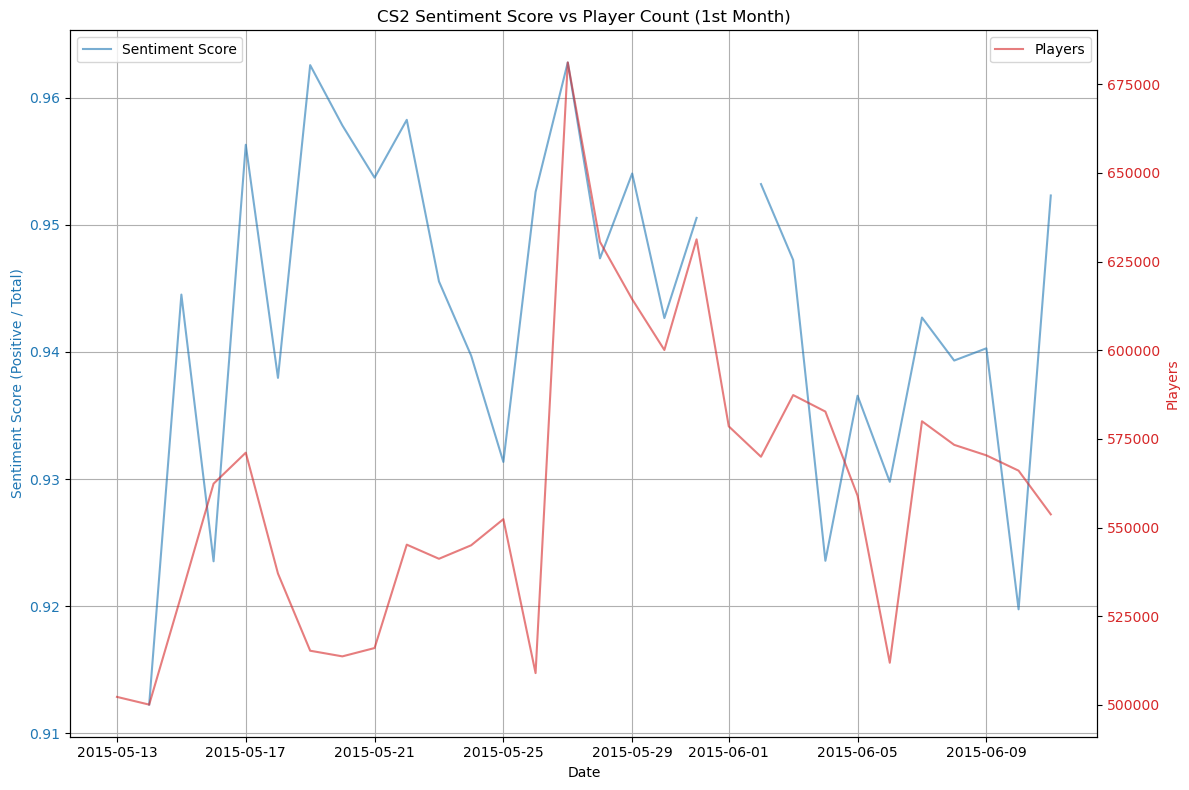

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
cs = pd.read_csv('./Reviews/csgo_reviews.csv')
cs_filtered = pd.read_csv('./PlayerCount/cs2playercount.csv')

# Ensure 'DateTime' columns are in datetime format
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')

# # Offset the sentiment data by 40 days
# cs['DateTime'] += pd.Timedelta(days=-40)

start_date = cs['DateTime'].min()
end_date = start_date + pd.Timedelta(days=30)

# Filter to only the first year of data
cs = cs[(cs['DateTime'] >= start_date) & (cs['DateTime'] < end_date)]
cs_filtered = cs_filtered[(cs_filtered['DateTime'] >= start_date) & (cs_filtered['DateTime'] < end_date)]

# Dictionary for parent items and their children
family = {'CS:GO Weapon Case': ['MP7 | Skulls', 'SG 553 | Ultraviolet', 'AUG | Wings', 'USP-S | Dark Water', 'Glock-18 | Dragon Tattoo', 'Desert Eagle | Hypnotic', 'AWP | Lightning Strike']}

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define color map for different lines
colors = plt.cm.tab20.colors
color_idx = 20

# Plot review_sentiment on the secondary y-axis
ax1.plot(cs['DateTime'], (cs['Positive reviews'] / (cs['Positive reviews'] - cs['Negative reviews']).where((cs['Positive reviews'] - cs['Negative reviews']) != 0, 1)), label='Sentiment Score', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Sentiment Score (Positive / Total)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()

# Plot player count data on the secondary y-axis
ax2.plot(cs_filtered['DateTime'], cs_filtered['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('CS2 Sentiment Score vs Player Count (1st Month)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

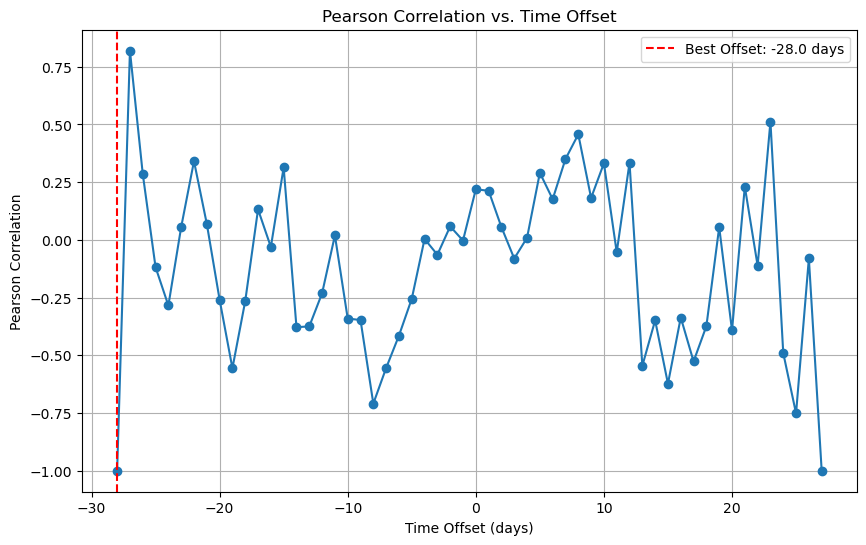

Best Offset: -28.0 days
Maximum Correlation: -1.0


In [24]:
import numpy as np

# Create an empty list to store correlation values
correlations = []

# Define range of time offsets to test (in days)
time_offsets = range(-60, 61)

# Loop over time offsets to find the one with the highest correlation
for offset in time_offsets:
    # Shift the 'Sentiment Score' time series by the offset
    shifted_sentiment = cs.copy()
    shifted_sentiment['DateTime'] += pd.Timedelta(days=offset)
    
    # Merge shifted sentiment and player count data on the DateTime column
    merged_data = pd.merge(shifted_sentiment[['DateTime', 'Positive reviews', 'Negative reviews']], 
                           cs_filtered[['DateTime', 'Players']], on='DateTime', how='inner')
    
    # Calculate Sentiment Score for merged data
    merged_data['Sentiment Score'] = merged_data['Positive reviews'] / (
        merged_data['Positive reviews'] - merged_data['Negative reviews']).replace(0, np.nan)
    
    # Drop rows with NaN values (resulting from divisions by zero or mismatched data)
    merged_data.dropna(subset=['Sentiment Score', 'Players'], inplace=True)
    
    # Calculate Pearson correlation
    if len(merged_data) > 1:  # Check for enough data points
        correlation = merged_data['Sentiment Score'].corr(merged_data['Players'])
        correlations.append((offset, correlation))
    else:
        correlations.append((offset, np.nan))  # Add NaN if insufficient data

# Convert the list of correlations to a DataFrame for easier analysis
correlations_df = pd.DataFrame(correlations, columns=['Offset (days)', 'Correlation'])

# Find the offset with the highest absolute correlation
best_offset = correlations_df.loc[correlations_df['Correlation'].abs().idxmax()]

# Plot correlations vs. time offsets
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset (days)'], correlations_df['Correlation'], marker='o')
plt.xlabel('Time Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation vs. Time Offset')
plt.axvline(best_offset['Offset (days)'], color='red', linestyle='--', label=f'Best Offset: {best_offset["Offset (days)"]} days')
plt.legend()
plt.grid(True)
plt.show()

# Output the best offset and correlation
print(f"Best Offset: {best_offset['Offset (days)']} days")
print(f"Maximum Correlation: {best_offset['Correlation']}")

              DateTime  Final price  Historical low
0  2012-11-01 17:03:08         9.99            9.99
1  2012-11-22 14:23:33        11.24            9.99
2  2012-11-27 12:48:39         7.49            7.49
3  2012-12-20 20:25:15        11.24            7.49
4  2012-12-27 20:22:13         7.49            7.49
..                 ...          ...             ...
83 2018-07-05 17:19:31        14.99            3.74
84 2018-11-21 18:53:24         7.49            3.74
85 2018-11-27 20:44:10        14.99            3.74
86 2018-12-06 21:34:09         0.00             NaN
87 2024-10-19 19:54:55         0.00             NaN

[88 rows x 3 columns]
              DateTime  Final price  Historical low  Players  Average Players
0  2012-11-01 17:03:08         9.99            9.99      NaN              NaN
1  2012-11-22 14:23:33        11.24            9.99      NaN              NaN
2  2012-11-27 12:48:39         7.49            7.49      NaN              NaN
3  2012-12-20 20:25:15        11.24      

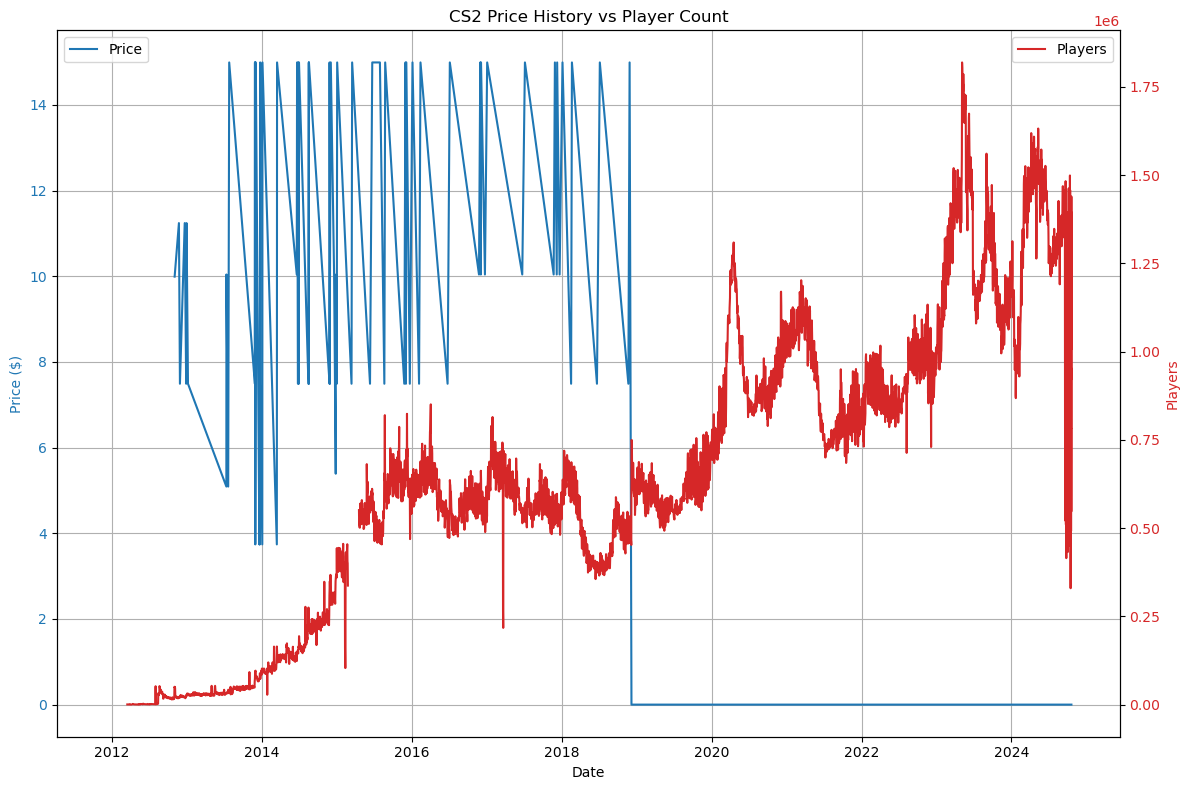

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
price_history = pd.read_csv('./GamePrice/cs2gamepricehistory.csv')
player_count = pd.read_csv('./PlayerCount/cs2playercount.csv')

# Ensure 'DateTime' columns are in datetime format
price_history['DateTime'] = pd.to_datetime(price_history['DateTime'], errors='coerce')
player_count['DateTime'] = pd.to_datetime(player_count['DateTime'], errors='coerce')

# Sort the price history by DateTime
price_history = price_history.sort_values('DateTime')

# Create a date range from the earliest to the latest date in both datasets
date_range = pd.date_range(start=min(price_history['DateTime'].min(), player_count['DateTime'].min()),
                           end=max(price_history['DateTime'].max(), player_count['DateTime'].max()),
                           freq='D')

# Create a new DataFrame with the full date range
full_data = pd.DataFrame({'DateTime': date_range})

# Set the DateTime as the index for both DataFrames
full_data.set_index('DateTime', inplace=True)
price_history.set_index('DateTime', inplace=True)

# Reindex price_history to match full_data and forward fill the prices
price_history_filled = price_history.reindex(full_data.index).ffill()

# Reset the index
full_data.reset_index(inplace=True)
price_history_filled.reset_index(inplace=True)

# Merge the filled price history data with full_data
full_data = pd.merge_asof(price_history.sort_values('DateTime'),
                              full_data.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('365D'), direction='backward')
# full_data = pd.merge(full_data, price_history_filled, on='DateTime', how='left')

print(full_data)

# Merge the player count data
full_data = pd.merge(full_data, player_count, on='DateTime', how='left')

print(full_data)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot price history on the primary y-axis
ax1.plot(full_data['DateTime'], full_data['Final price'], label='Price', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()

# Plot player count data on the secondary y-axis
ax2.plot(player_count['DateTime'], player_count['Players'], label='Players', color='tab:red')
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('CS2 Price History vs Player Count')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

0         2013-04-01 01:00:00
1         2014-04-01 01:00:00
2         2015-04-01 01:00:00
3         2016-04-01 01:00:00
4         2017-04-01 01:00:00
                  ...        
1071332   2024-09-30 18:00:00
1071333   2024-09-30 19:00:00
1071334   2024-09-30 20:00:00
1071335   2024-09-30 21:00:00
1071336   2024-09-30 23:00:00
Name: DateTime, Length: 1071337, dtype: datetime64[ns]


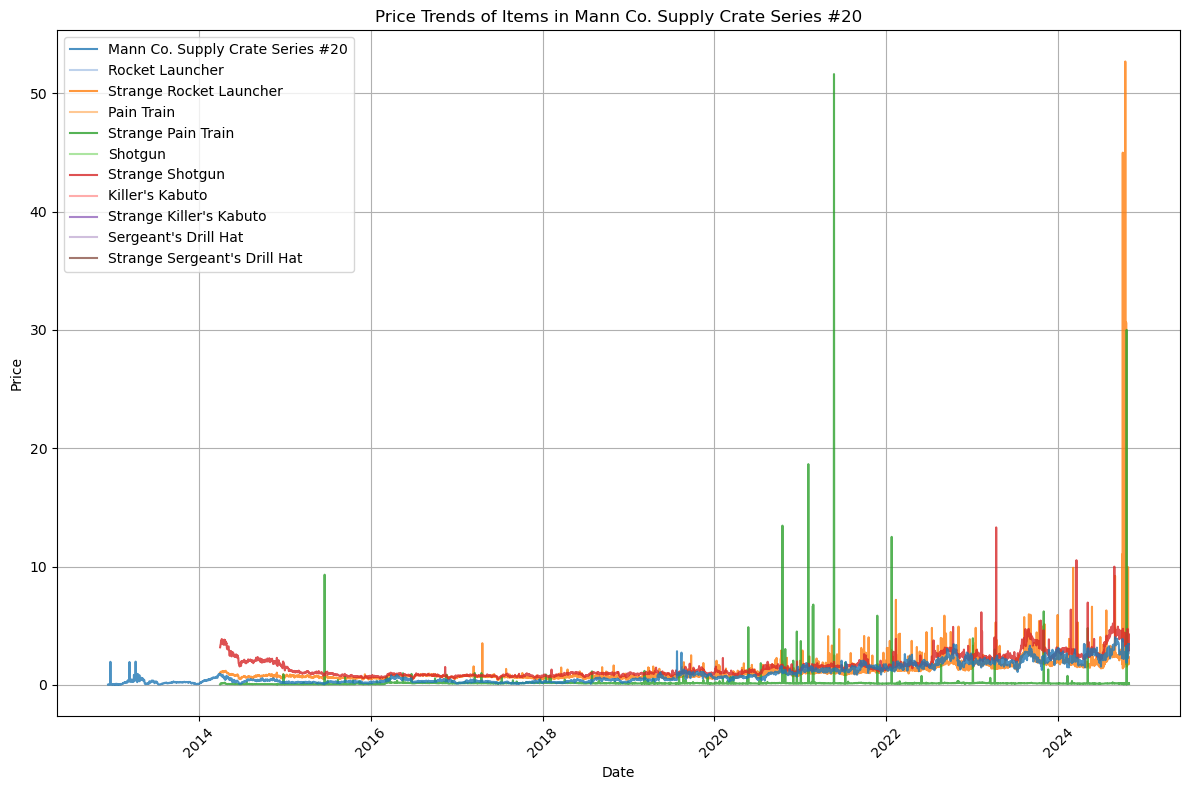

In [26]:
tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True)

# tf['DateTime'] = pd.to_datetime(tf['DateTime'])

print(tf['DateTime'])

family = {"Mann Co. Supply Crate Series #20" : ['Rocket Launcher', 'Pain Train', 'Shotgun', "Killer's Kabuto", "Sergeant's Drill Hat"]}

# Ensure 'DateTime' column is in datetime format
# tf['DateTime'] = pd.to_datetime(tf['DateTime'], errors='coerce')

# Set up the plot
plt.figure(figsize=(12, 8))

# conditions = ['(Battle-Scarred)', '(Well-Worn)', '(Field-Tested)', '(Minimal Wear)', '(Factory New)']
qualities = ['Strange']

# Initialize color map
colors = plt.cm.tab20.colors
# Track color index
color_idx = 20

# Loop through each parent and their children in the family dictionary
for parent, children in family.items():
    item_data = tf[tf['Item Name'] == parent]

    # Plot the price over time for each child item

    # # Group by date and calculate the average price for each day
    item_data_agg = item_data.groupby('DateTime')['Price'].mean().reset_index()

    # # Plot the aggregated price over time
    plt.plot(item_data_agg['DateTime'], item_data_agg['Price'], label=parent, color=colors[color_idx % len(colors)], alpha=0.8, zorder=5)
    color_idx += 1

    for child in children:
        # for condition in conditions[2:3]:
        # Filter the DataFrame for each child item
        item_data = tf[tf['Item Name'] == (child)]
        
        item_data_agg = item_data.groupby('DateTime')['Price'].mean().reset_index()

        # Plot the price over time for each child item
        plt.plot(item_data_agg['DateTime'], item_data_agg['Price'], label=child, color=colors[color_idx % len(colors)], alpha=0.8)
        color_idx += 1

        # Filter the DataFrame for each child item
        item_data = tf[tf['Item Name'] == (qualities[0] + ' ' + child)]

        item_data_agg = item_data.groupby('DateTime')['Price'].mean().reset_index()

        # Plot the price over time for each child item
        plt.plot(item_data_agg['DateTime'], item_data_agg['Price'], label=(qualities[0] + ' ' + child), color=colors[color_idx % len(colors)], alpha=0.8)
        color_idx += 1

        # # Filter the DataFrame for each child item
        # item_data = tf[tf['Item Name'] == (qualities[1] + ' ' + child)]

        # item_data_agg = item_data.groupby('DateTime')['Price'].mean().reset_index()

        # # Plot the price over time for each child item
        # plt.plot(item_data_agg['DateTime'], item_data_agg['Price'], label=(qualities[1] + ' ' + child), color=colors[color_idx % len(colors)], alpha=0.8)
        # color_idx += 1
        

# Customize the plot
plt.title('Price Trends of Items in Mann Co. Supply Crate Series #20')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')  # Adds a legend to differentiate items
plt.xticks(rotation=45)       # Rotate x-axis dates for readability
plt.grid(True)                # Add grid for easier reading of values

# Show the plot
plt.tight_layout()            # Adjust layout to prevent overlap
plt.show()

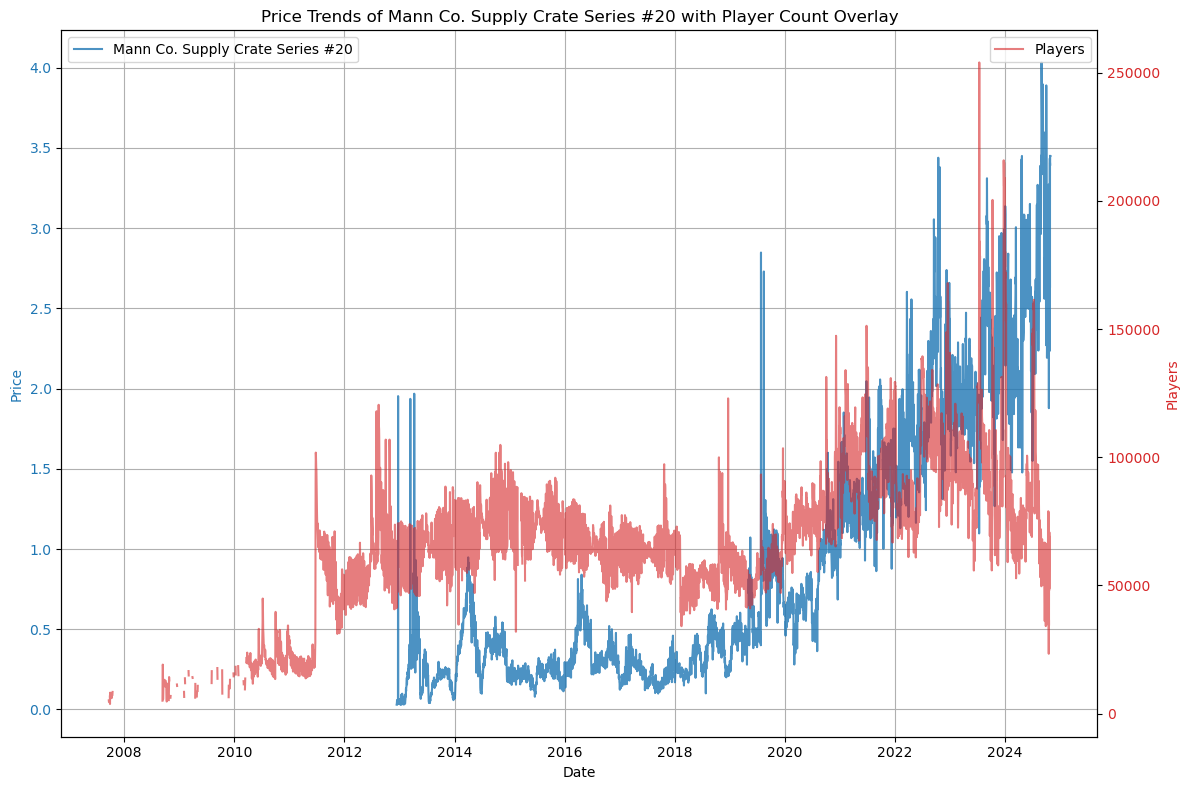

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True)
tf_filtered = pd.read_csv('./PlayerCount/tf2playercount.csv')

# Ensure 'DateTime' columns are in datetime format
tf['DateTime'] = pd.to_datetime(tf['DateTime'], errors='coerce')
tf_filtered['DateTime'] = pd.to_datetime(tf_filtered['DateTime'], errors='coerce')

# Dictionary for parent items and their children
family = {"Mann Co. Supply Crate Series #20" : ['Rocket Launcher', 'Pain Train', 'Shotgun', "Killer's Kabuto", "Sergeant's Drill Hat"]}

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define color map for different lines
colors = plt.cm.tab20.colors
color_idx = 20

# Plot the parent item price trend over time on the primary y-axis
for parent, children in family.items():
    item_data = tf[tf['Item Name'] == parent]
    
    # Group by date if needed and plot
    item_data_agg = item_data.groupby('DateTime')['Price'].mean().reset_index()
    ax1.plot(item_data_agg['DateTime'], item_data_agg['Price'], label=parent, color=colors[color_idx % len(colors)], alpha=0.8, zorder=10)
    color_idx += 1

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()

# Plot player count data on the secondary y-axis
ax2.plot(tf_filtered['DateTime'], tf_filtered['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Price Trends of Mann Co. Supply Crate Series #20 with Player Count Overlay')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

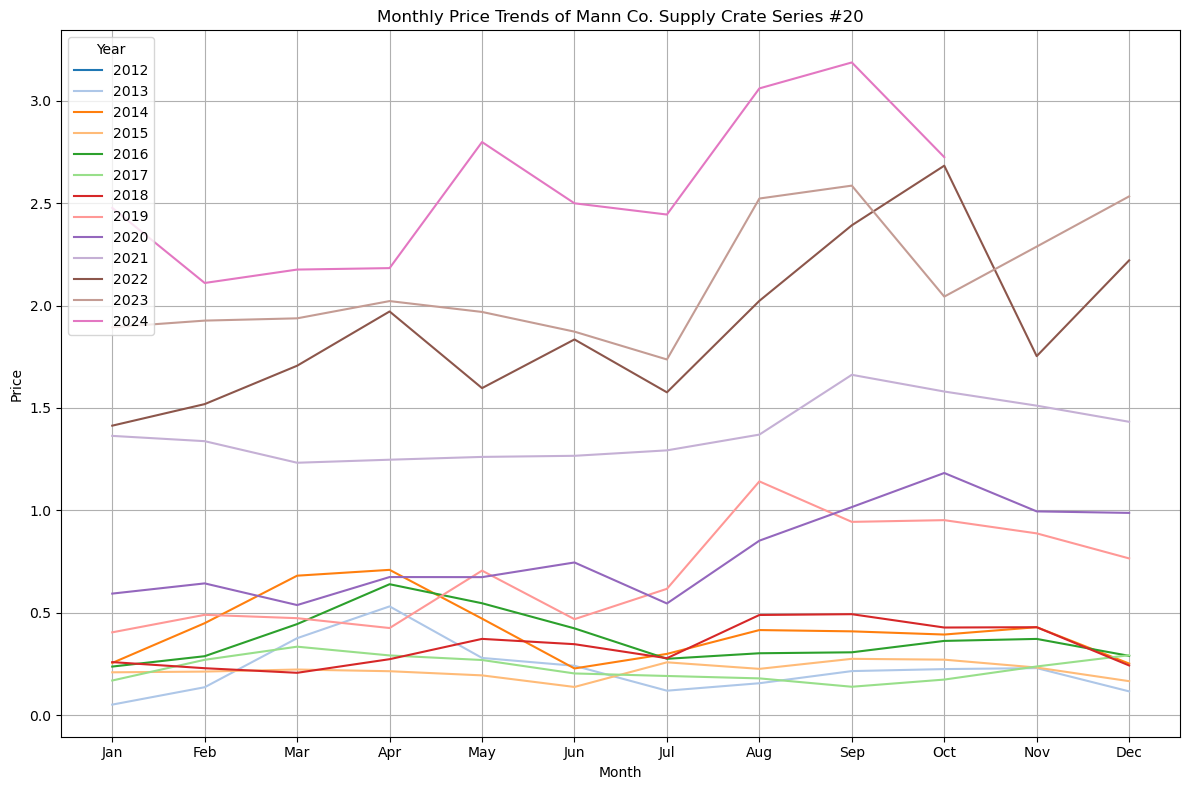

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Load the data
tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True)

# Ensure 'DateTime' column is in datetime format
tf['DateTime'] = pd.to_datetime(tf['DateTime'], errors='coerce')

# Dictionary for parent items and their children
family = {"Mann Co. Supply Crate Series #20": ['Rocket Launcher', 'Pain Train', 'Shotgun', "Killer's Kabuto", "Sergeant's Drill Hat"]}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define color map for different lines
colors = plt.cm.tab20.colors

# Get the parent item
parent = list(family.keys())[0]

# Filter data for the parent item and create a copy
item_data = tf[tf['Item Name'] == parent].copy()

# Extract year and month from DateTime
item_data['Year'] = item_data['DateTime'].dt.year
item_data['Month'] = item_data['DateTime'].dt.month

# Group by Year and Month, and calculate mean price
item_data_agg = item_data.groupby(['Year', 'Month'])['Price'].mean().reset_index()

# Get unique years
years = sorted(item_data_agg['Year'].unique())

# Plot a line for each year
for i, year in enumerate(years):
    year_data = item_data_agg[item_data_agg['Year'] == year]
    ax.plot(year_data['Month'], year_data['Price'], label=str(year), color=colors[i % len(colors)])

# Customize the x-axis
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

# Title and grid for clarity
plt.title(f'Monthly Price Trends of {parent}')
ax.legend(title='Year', loc='upper left')
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

              DateTime  Initial price  Final price
0  2012-11-22 00:43:46          19.99         9.99
1  2013-07-25 15:40:45          19.99        19.99
2  2013-11-27 18:22:00          19.99         9.99
3  2013-11-28 04:23:12          19.99        19.99
4  2013-11-28 05:30:36          19.99         9.99
..                 ...            ...          ...
80 2024-03-14 18:02:52          19.99         0.99
81 2024-03-21 17:52:24          19.99        19.99
82 2024-06-27 19:06:23          19.99         1.99
83 2024-07-11 17:54:06          19.99        19.99
84 2024-10-27 18:38:24          19.99        19.99

[85 rows x 3 columns]
              DateTime  Initial price  Final price  Players  Average Players
0  2012-11-22 00:43:46          19.99         9.99      NaN              NaN
1  2013-07-25 15:40:45          19.99        19.99      NaN              NaN
2  2013-11-27 18:22:00          19.99         9.99      NaN              NaN
3  2013-11-28 04:23:12          19.99        19.99      N

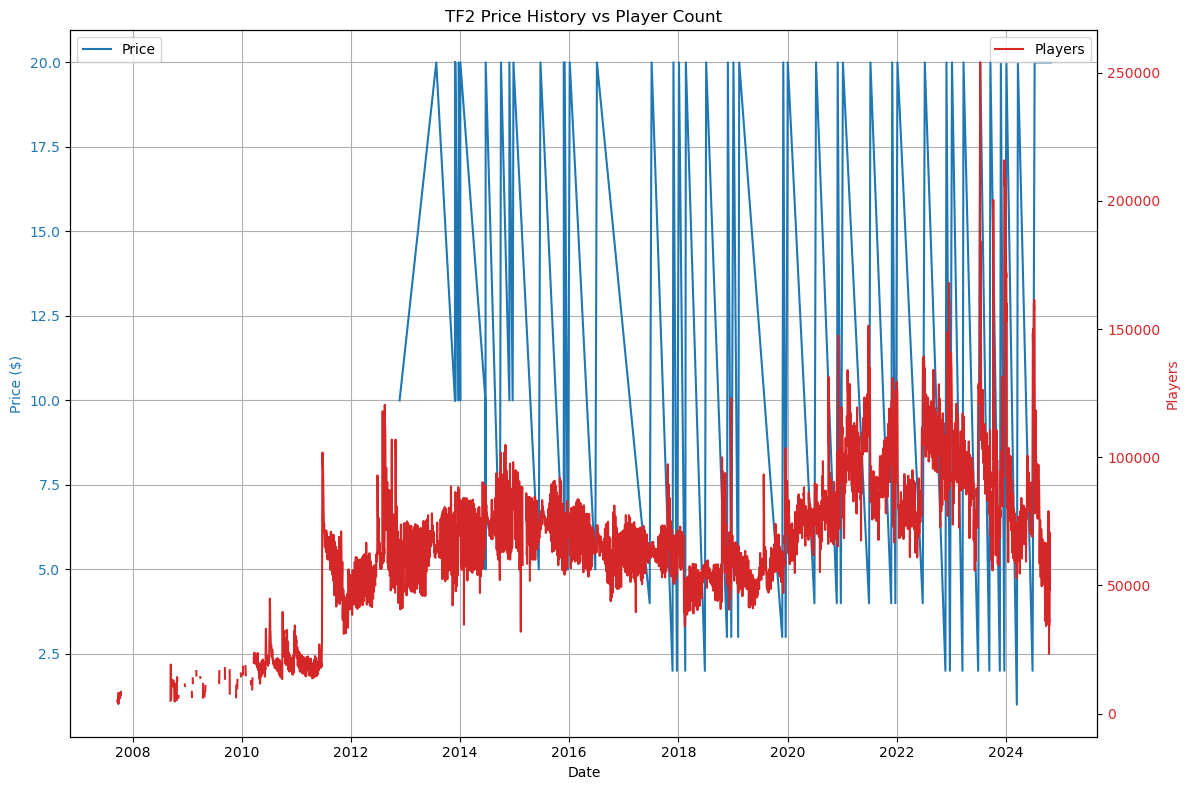

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
price_history = pd.read_csv('./GamePrice/orangeboxgamepricehistory.csv')
player_count = pd.read_csv('./PlayerCount/tf2playercount.csv')

# Ensure 'DateTime' columns are in datetime format
price_history['DateTime'] = pd.to_datetime(price_history['DateTime'], errors='coerce')
player_count['DateTime'] = pd.to_datetime(player_count['DateTime'], errors='coerce')

# Sort the price history by DateTime
price_history = price_history.sort_values('DateTime')

# Create a date range from the earliest to the latest date in both datasets
date_range = pd.date_range(start=min(price_history['DateTime'].min(), player_count['DateTime'].min()),
                           end=max(price_history['DateTime'].max(), player_count['DateTime'].max()),
                           freq='D')

# Create a new DataFrame with the full date range
full_data = pd.DataFrame({'DateTime': date_range})

# Set the DateTime as the index for both DataFrames
full_data.set_index('DateTime', inplace=True)
price_history.set_index('DateTime', inplace=True)

# Reindex price_history to match full_data and forward fill the prices
price_history_filled = price_history.reindex(full_data.index).ffill()

# Reset the index
full_data.reset_index(inplace=True)
price_history_filled.reset_index(inplace=True)

# Merge the filled price history data with full_data
full_data = pd.merge_asof(price_history.sort_values('DateTime'),
                              full_data.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('365D'), direction='backward')
# full_data = pd.merge(full_data, price_history_filled, on='DateTime', how='left')

print(full_data)

# Merge the player count data
full_data = pd.merge(full_data, player_count, on='DateTime', how='left')

print(full_data)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot price history on the primary y-axis
ax1.plot(full_data['DateTime'], full_data['Final price'], label='Price', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()

# Plot player count data on the secondary y-axis
ax2.plot(player_count['DateTime'], player_count['Players'], label='Players', color='tab:red')
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('TF2 Price History vs Player Count')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

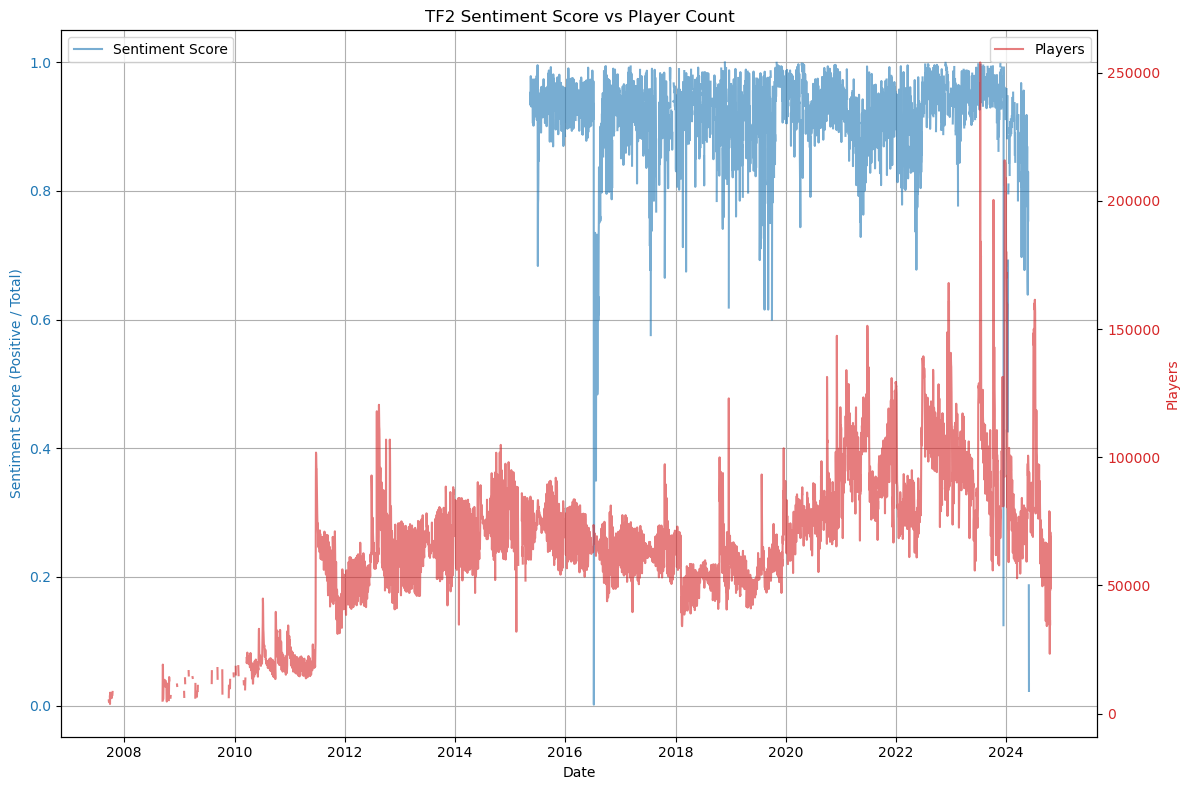

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
cs = pd.read_csv('./Reviews/tf2_reviews.csv')
cs_filtered = pd.read_csv('./PlayerCount/tf2playercount.csv')

# Ensure 'DateTime' columns are in datetime format
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')


# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define color map for different lines
colors = plt.cm.tab20.colors
color_idx = 20

# Plot review_sentiment on the secondary y-axis
ax1.plot(cs['DateTime'], (cs['Positive reviews'] / (cs['Positive reviews'] - cs['Negative reviews']).where((cs['Positive reviews'] - cs['Negative reviews']) != 0, 1)), label='Sentiment Score', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Sentiment Score (Positive / Total)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()

# Plot player count data on the secondary y-axis
ax2.plot(cs_filtered['DateTime'], cs_filtered['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('TF2 Sentiment Score vs Player Count')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\chaoa\AppData\Local\Temp\ipykernel_17464\2862453555.py:6: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('./CS2Reviews/reviews_730_combined_2.csv')


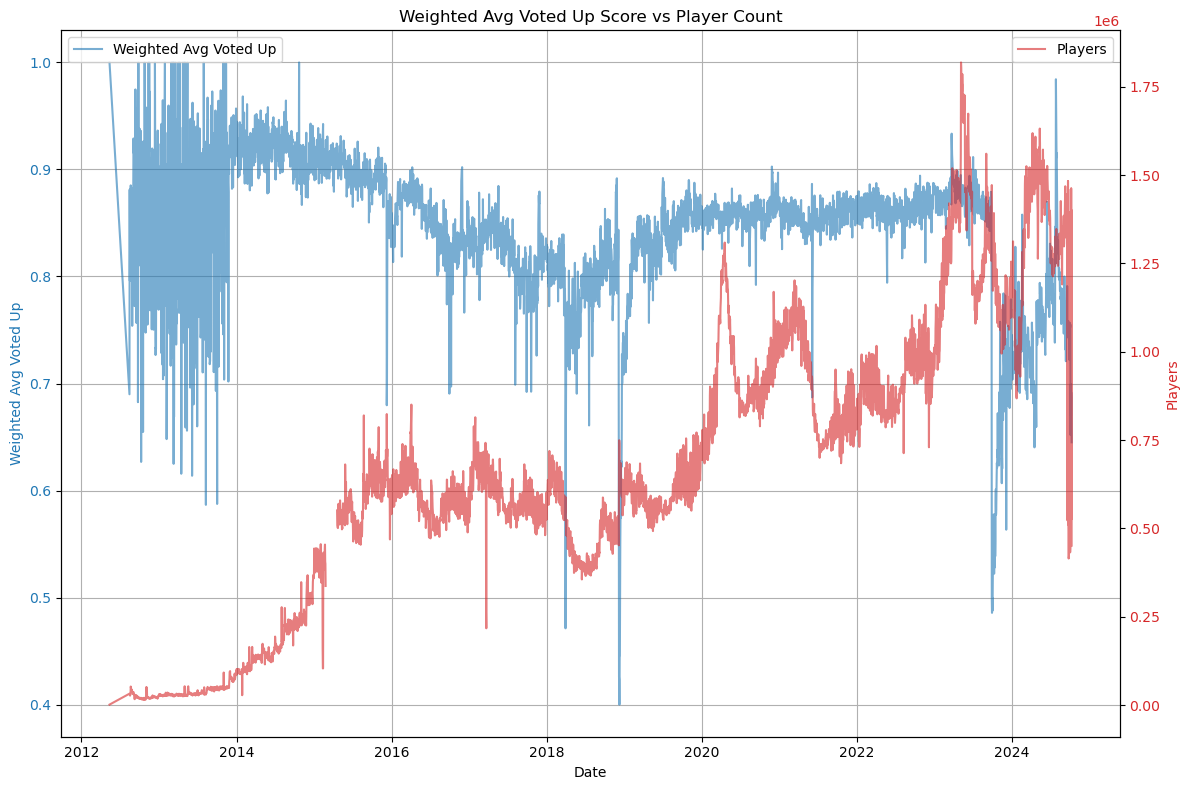

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the review data with weighted_avg_voted_up and player count data
reviews = pd.read_csv('./CS2Reviews/reviews_730_combined_2.csv')
player_count = pd.read_csv('./PlayerCount/cs2playercount.csv')

# Convert 'DateTime' columns to datetime format
reviews['date_created'] = pd.to_datetime(reviews['timestamp_created'], unit='s').dt.date
player_count['DateTime'] = pd.to_datetime(player_count['DateTime']).dt.date

# Calculate log of review length and weighted voted_up score as before
reviews['log_review_length'] = np.log(reviews['review_length'] + 1)
reviews['weighted_voted_up'] = reviews['voted_up'] * reviews['log_review_length']

# Group by date and calculate daily weighted_avg_voted_up
daily_summary = reviews.groupby('date_created').agg({
    'log_review_length': 'sum',             # Total log review length for weighting
    'weighted_voted_up': 'sum'              # Sum of weighted voted_up
}).reset_index()
daily_summary['weighted_avg_voted_up'] = daily_summary['weighted_voted_up'] / daily_summary['log_review_length']

# Merge with player count data on date
merged_data = pd.merge(daily_summary, player_count, left_on='date_created', right_on='DateTime', how='inner')

# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot weighted_avg_voted_up on the primary y-axis
ax1.plot(merged_data['DateTime'], merged_data['weighted_avg_voted_up'], label='Weighted Avg Voted Up', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Weighted Avg Voted Up', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()
ax2.plot(merged_data['DateTime'], merged_data['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Weighted Avg Voted Up Score vs Player Count')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\chaoa\AppData\Local\Temp\ipykernel_17464\2792216457.py:6: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('./CS2Reviews/reviews_730_combined_2.csv')


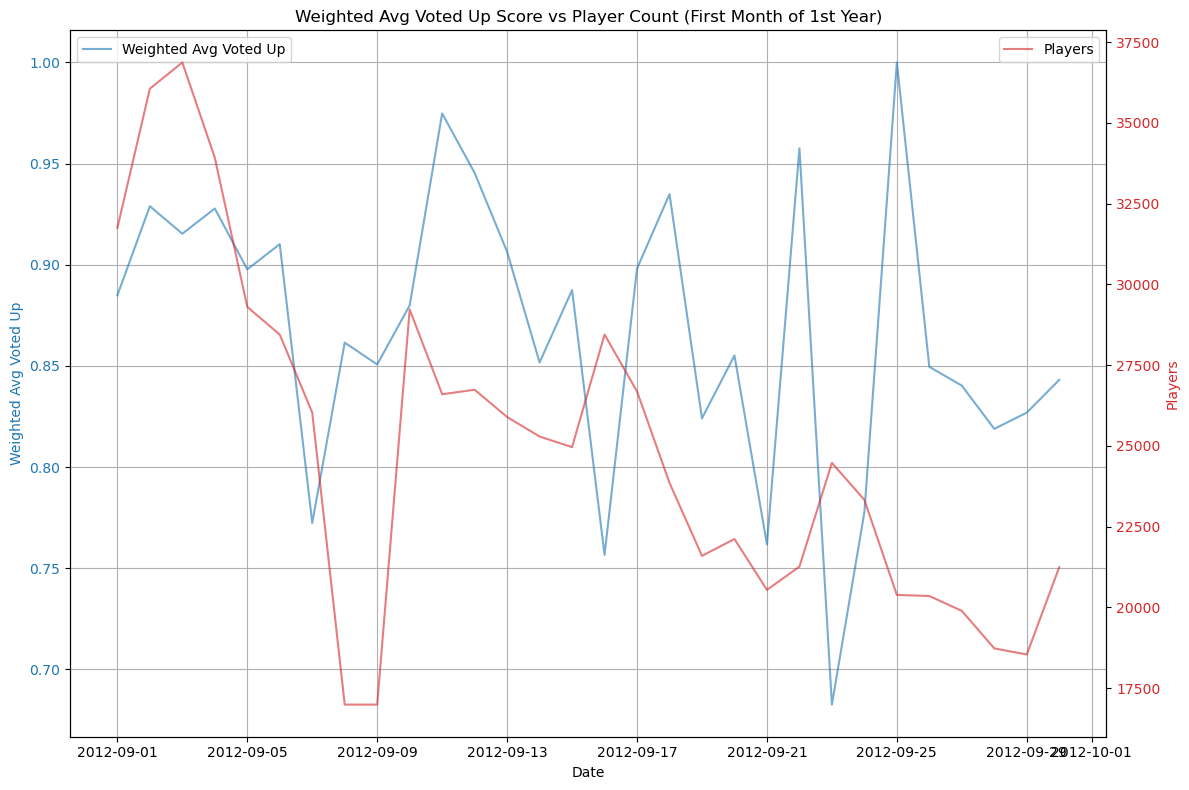

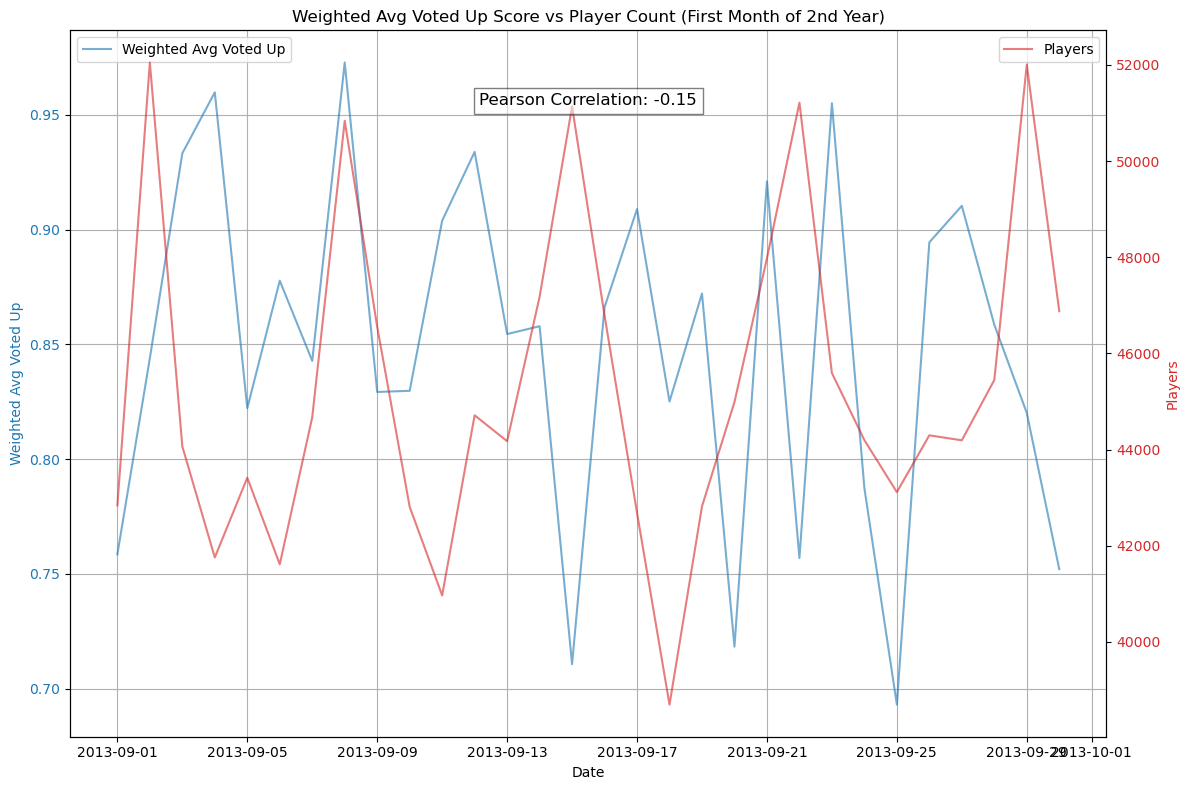

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the review data with weighted_avg_voted_up and player count data
reviews = pd.read_csv('./CS2Reviews/reviews_730_combined_2.csv')
player_count = pd.read_csv('./PlayerCount/cs2playercount.csv')

# Convert 'DateTime' columns to datetime format
reviews['date_created'] = pd.to_datetime(reviews['timestamp_created'], unit='s').dt.date
player_count['DateTime'] = pd.to_datetime(player_count['DateTime']).dt.date

# Calculate log of review length and weighted voted_up score as before
reviews['log_review_length'] = np.log(reviews['review_length'] + 1)
reviews['weighted_voted_up'] = reviews['voted_up'] * reviews['log_review_length']

# Group by date and calculate daily weighted_avg_voted_up
daily_summary = reviews.groupby('date_created').agg({
    'log_review_length': 'sum',             # Total log review length for weighting
    'weighted_voted_up': 'sum'              # Sum of weighted voted_up
}).reset_index()
daily_summary['weighted_avg_voted_up'] = daily_summary['weighted_voted_up'] / daily_summary['log_review_length']

# Merge with player count data on date
merged_data = pd.merge(daily_summary, player_count, left_on='date_created', right_on='DateTime', how='inner')

start_date = pd.to_datetime("2012-09-01").date()
end_date = pd.to_datetime("2012-10-01").date()
filtered_data = merged_data[(merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] < end_date)]
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot weighted_avg_voted_up on the primary y-axis
ax1.plot(filtered_data['DateTime'], filtered_data['weighted_avg_voted_up'], label='Weighted Avg Voted Up', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Weighted Avg Voted Up', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()
ax2.plot(filtered_data['DateTime'], filtered_data['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Weighted Avg Voted Up Score vs Player Count (First Month of 1st Year)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

start_date = pd.to_datetime("2013-09-01").date()
end_date = pd.to_datetime("2013-10-01").date()
filtered_data = merged_data[(merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] < end_date)]
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot weighted_avg_voted_up on the primary y-axis
ax1.plot(filtered_data['DateTime'], filtered_data['weighted_avg_voted_up'], label='Weighted Avg Voted Up', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Weighted Avg Voted Up', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()
ax2.plot(filtered_data['DateTime'], filtered_data['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Weighted Avg Voted Up Score vs Player Count (First Month of 2nd Year)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

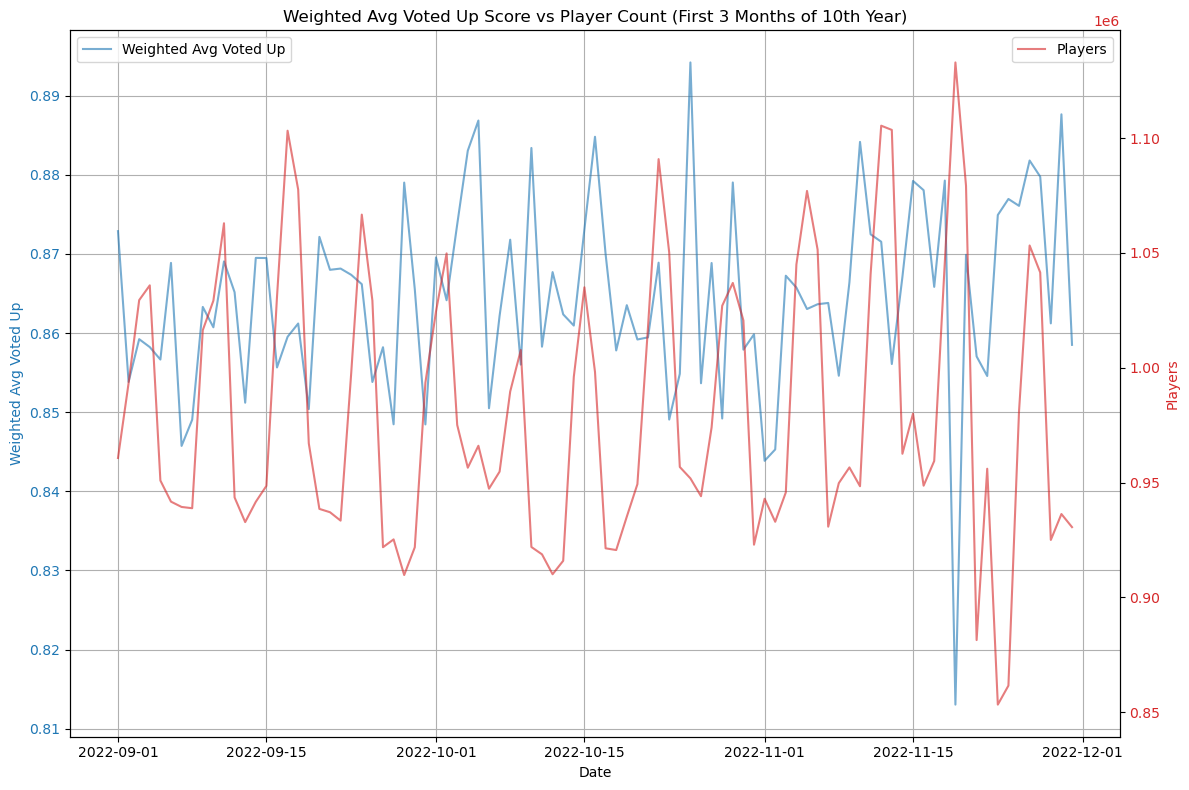

In [33]:
start_date = pd.to_datetime("2022-09-01").date()
end_date = pd.to_datetime("2022-12-01").date()
filtered_data = merged_data[(merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] < end_date)]
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot weighted_avg_voted_up on the primary y-axis
ax1.plot(filtered_data['DateTime'], filtered_data['weighted_avg_voted_up'], label='Weighted Avg Voted Up', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Weighted Avg Voted Up', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()
ax2.plot(filtered_data['DateTime'], filtered_data['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Weighted Avg Voted Up Score vs Player Count (First 3 Months of 10th Year)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

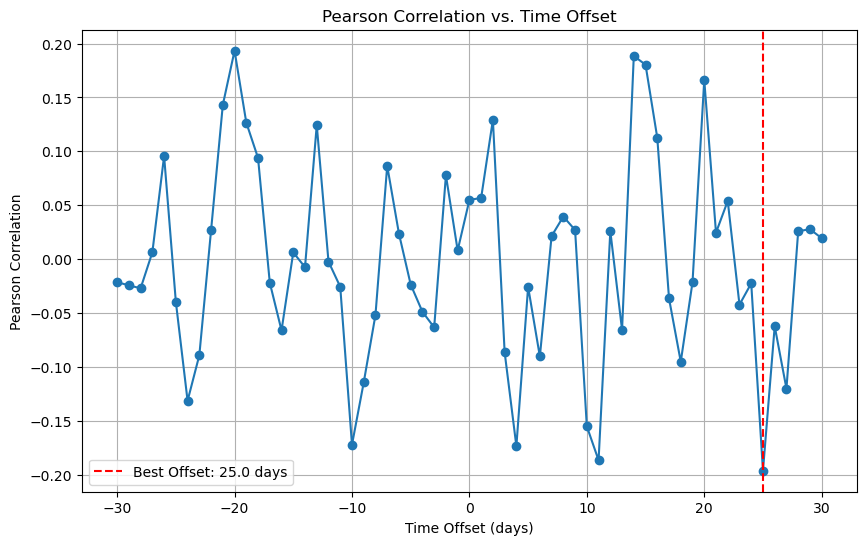

Best Offset: 25.0 days
Maximum Correlation: -0.19616818894723004


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'DateTime' is in datetime format
merged_data['DateTime'] = pd.to_datetime(merged_data['DateTime'], errors='coerce')
merged_data.dropna(subset=['DateTime'], inplace=True)

# Filter data within the specified date range
start_date = pd.to_datetime("2013-01-01")
end_date = pd.to_datetime("2013-04-01")
filtered_data = merged_data[(merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] < end_date)].copy()

# Create an empty list to store correlation values
correlations = []

# Define range of time offsets to test (in days)
time_offsets = range(-30, 31)  # -30 to 30 days

# Loop over time offsets to find the one with the highest correlation
for offset in time_offsets:
    # Shift the 'weighted_avg_voted_up' time series by the offset
    shifted_data = filtered_data.copy()
    shifted_data['DateTime'] += pd.Timedelta(days=offset)
    
    # Merge shifted data with the player count data
    merged_data = pd.merge(shifted_data[['DateTime', 'weighted_avg_voted_up']], 
                           filtered_data[['DateTime', 'Players']], on='DateTime', how='inner')
    
    # Drop rows with NaN values (resulting from mismatched data or insufficient data after shifting)
    merged_data.dropna(subset=['weighted_avg_voted_up', 'Players'], inplace=True)
    
    # Calculate Pearson correlation
    if len(merged_data) > 1:  # Ensure there are enough data points to calculate correlation
        correlation = merged_data['weighted_avg_voted_up'].corr(merged_data['Players'])
        correlations.append((offset, correlation))
    else:
        correlations.append((offset, np.nan))  # If insufficient data, store NaN correlation

# Convert the list of correlations to a DataFrame for easier analysis
correlations_df = pd.DataFrame(correlations, columns=['Offset (days)', 'Correlation'])

# Find the offset with the highest absolute correlation
best_offset = correlations_df.loc[correlations_df['Correlation'].abs().idxmax()]

# Plot correlations vs. time offsets
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset (days)'], correlations_df['Correlation'], marker='o')
plt.xlabel('Time Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation vs. Time Offset')
plt.axvline(best_offset['Offset (days)'], color='red', linestyle='--', label=f'Best Offset: {best_offset["Offset (days)"]} days')
plt.legend()
plt.grid(True)
plt.show()

# Output the best offset and correlation
print(f"Best Offset: {best_offset['Offset (days)']} days")
print(f"Maximum Correlation: {best_offset['Correlation']}")

In [35]:
start_date = pd.to_datetime("2013-01-01").date()
end_date = pd.to_datetime("2013-02-01").date()
filtered_data = merged_data[(merged_data['DateTime'] >= start_date) & (merged_data['DateTime'] < end_date)]
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot weighted_avg_voted_up on the primary y-axis
ax1.plot(filtered_data['DateTime'], filtered_data['weighted_avg_voted_up'], label='Weighted Avg Voted Up', color='tab:blue', alpha=0.6)
ax1.set_ylabel('Weighted Avg Voted Up', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Customize the primary y-axis (left)
ax1.set_xlabel('Date')

# Create a secondary y-axis for the player count
ax2 = ax1.twinx()
ax2.plot(filtered_data['DateTime'], filtered_data['Players'], label='Players', color='tab:red', alpha=0.6)
ax2.set_ylabel('Players', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and grid for clarity
plt.title('Weighted Avg Voted Up Score vs Player Count (Tenth Year)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

TypeError: Invalid comparison between dtype=datetime64[ns] and date

##### 2.3 Concurrent Players (Social Data)

CS2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         6258 non-null   object 
 1   Players          6095 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 146.8+ KB


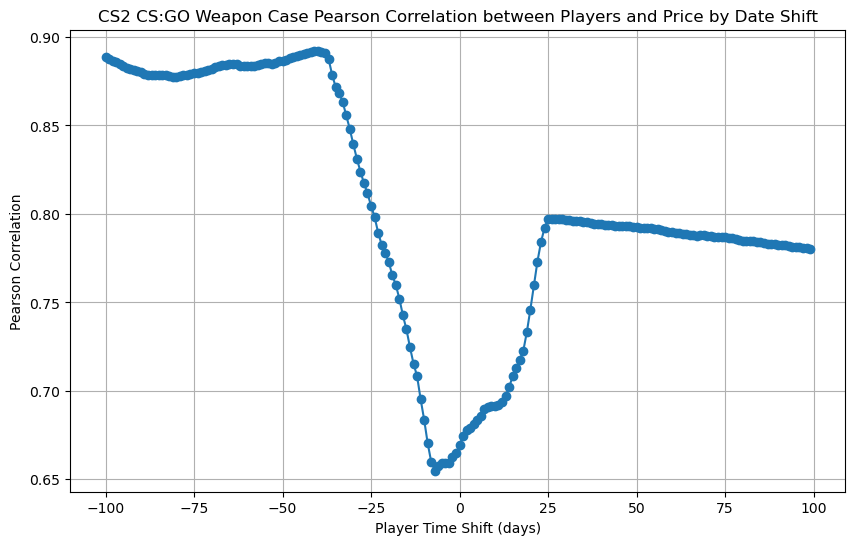

First local maximum to the left: Offset=-41.0, Correlation=0.89


In [49]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv')

cs_players = pd.read_csv('./PlayerCount/cs2playercount.csv')

cs_players.info()


# Ensure DateTime columns are properly formatted
cs_players['DateTime'] = pd.to_datetime(cs_players['DateTime'], errors='coerce')
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')

# Filter the tf dataset for a specific item
item_name = 'CS:GO Weapon Case'

cs_filtered = cs[cs['Item Name'] == item_name]

# cases = [
#         'CS:GO Weapon Case',
#           'eSports 2013 Case',
#           'Operation Bravo Case',
#           'CS:GO Weapon Case 2',
#           'eSports 2013 Winter Case',
#           'Winter Offensive Case',
#           'CS:GO Weapon Case 3',
#           'Operation Phoenix Case',
#           'Huntsman Weapon Case'
#           'Operation Breakout Weapon Case',
#           'eSports 2014 Summer Case',
#           'Operation Vanguard Case',
#           'Chroma Case',
#           'Chroma 2 Case',
#           'Falchion Case',
#           'Shadow Case',
#           'Revolver Case',
#           'Operation Wildfire Case',
#           'Chroma 3 Case',
#           'Gamma Case',
#           'Gamma 2 Case',
#           'Glove Case',
#           'Spectrum Case',
#           'Operation Hydra Case',
#           'Spectrum 2 Case',
#           'Clutch Case',
#           'Horizon Case',
#           'Danger Zone Case',
#           'Prisma Case',
#           'Shattered Web Case',
#           'CS20 Case',
#           'Prisma 2 Case',
#           'Fracture Case',
#           'Operation Broken Fang Case',
#           'Snakebite Case',
#           'Operation Riptide Case',
#           'Dreams & Nightmares Case',
#           'Recoil Case',
#           'Revolution Case',
#           'Kilowatt Case',
#           'Gallery Case',
#           ]

# cs_filtered = cs[cs['Item Name'].isin(cases)]

# print(tf_filtered)



correlations = []

for offset in range(-100, 100):
    cs_players_offset = cs_players.copy()

    cs_players_offset['DateTime'] = pd.to_datetime(cs_players['DateTime']) - pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_players_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')

    merged_df.dropna(subset=['Players', 'Price'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Players'], merged_df['Price'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Identify the first local maximum on the left side (negative offsets)
left_side = correlations_df[correlations_df['Offset'] < 0]
local_max_idx = left_side['Correlation'].idxmax()
local_max = correlations_df.iloc[local_max_idx]

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Time Shift (days)')
plt.ylabel('Pearson Correlation')
plt.title(f'CS2 {item_name} Pearson Correlation between Players and Price by Date Shift')
plt.grid(True)
plt.show()

# Print the first local maximum on the left side
print(f"First local maximum to the left: Offset={local_max.Offset}, Correlation={local_max.Correlation:.2f}")

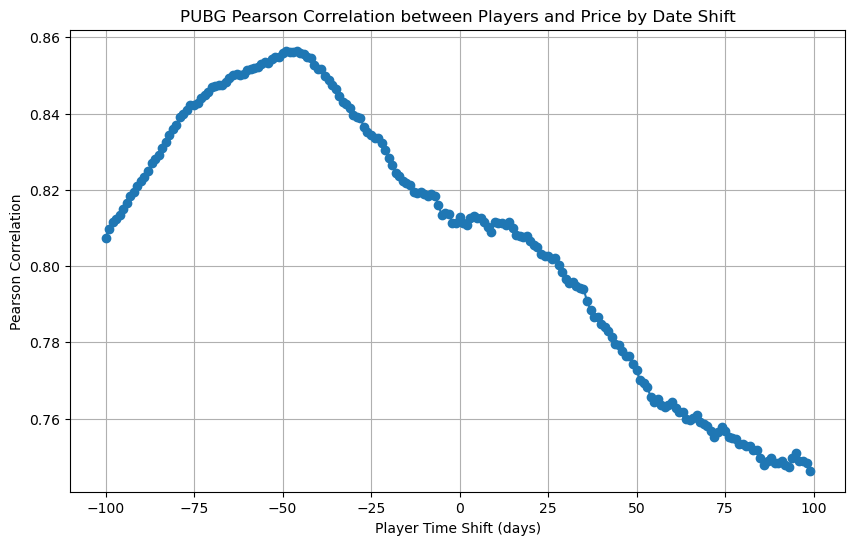

First local maximum to the left: Offset=-49.0, Correlation=0.86


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json

# Load the JSON price data
with open('pubg_price_history.json', 'r') as f:
    price_data_json = json.load(f)

# Convert JSON data to DataFrame
price_data = pd.DataFrame(price_data_json['prices'], columns=['DateTime', 'Price', 'Players'])
price_data['DateTime'] = pd.to_datetime(price_data['DateTime'], format="%b %d %Y %H: +0")
price_data['Price'] = price_data['Price'].astype(float)
price_data['Players'] = price_data['Players'].astype(int)

# Load the player count data from CSV
player_data = pd.read_csv('pubg_playercount.csv')
player_data['DateTime'] = pd.to_datetime(player_data['DateTime'], errors='coerce')

# Perform time-shifted correlation calculation
correlations = []
for offset in range(-100, 100):
    shifted_player_data = player_data.copy()
    shifted_player_data['DateTime'] = shifted_player_data['DateTime'] - pd.Timedelta(days=offset)

    # Merge on DateTime within 1-day tolerance
    merged_data = pd.merge_asof(
        price_data.sort_values('DateTime'),
        shifted_player_data.sort_values('DateTime'),
        on='DateTime',
        suffixes=('', '_shifted'),
        tolerance=pd.Timedelta('1D'),
        direction='nearest'
    )

    merged_data.dropna(subset=['Players_shifted', 'Price'], inplace=True)

    # Calculate correlation if there are enough data points
    if merged_data.shape[0] < 2:
        continue

    corr, _ = pearsonr(merged_data['Players_shifted'], merged_data['Price'])
    correlations.append((offset, corr))

# Convert correlation results to DataFrame
correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Identify the first local maximum on the left side (negative offsets)
left_side = correlations_df[correlations_df['Offset'] < 0]
local_max_idx = left_side['Correlation'].idxmax()
local_max = correlations_df.iloc[local_max_idx]

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Time Shift (days)')
plt.ylabel('Pearson Correlation')
plt.title('PUBG Pearson Correlation between Players and Price by Date Shift')
plt.grid(True)

plt.show()

# Print the first local maximum on the left side
print(f"First local maximum to the left: Offset={local_max.Offset}, Correlation={local_max.Correlation:.2f}")

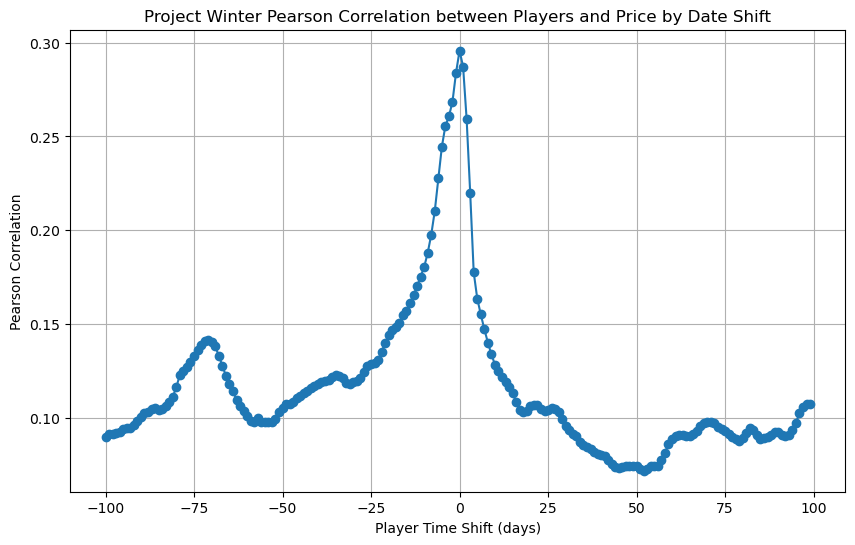

First local maximum to the left: Offset=-1.0, Correlation=0.28


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json

# Load the JSON price data
with open('Project_Winter_Price_History.json', 'r') as f:
    price_data_json = json.load(f)

# Convert JSON data to DataFrame
price_data = pd.DataFrame(price_data_json['prices'], columns=['DateTime', 'Price', 'Players'])
price_data['DateTime'] = pd.to_datetime(price_data['DateTime'], format="%b %d %Y %H: +0")
price_data['Price'] = price_data['Price'].astype(float)
price_data['Players'] = price_data['Players'].astype(int)

# Load the player count data from CSV
player_data = pd.read_csv('projectwinter_playercount.csv')
player_data['DateTime'] = pd.to_datetime(player_data['DateTime'], errors='coerce')

# Perform time-shifted correlation calculation
correlations = []
for offset in range(-100, 100):
    shifted_player_data = player_data.copy()
    shifted_player_data['DateTime'] = shifted_player_data['DateTime'] - pd.Timedelta(days=offset)

    # Merge on DateTime within 1-day tolerance
    merged_data = pd.merge_asof(
        price_data.sort_values('DateTime'),
        shifted_player_data.sort_values('DateTime'),
        on='DateTime',
        suffixes=('', '_shifted'),
        tolerance=pd.Timedelta('1D'),
        direction='nearest'
    )

    merged_data.dropna(subset=['Players_shifted', 'Price'], inplace=True)

    # Calculate correlation if there are enough data points
    if merged_data.shape[0] < 2:
        continue

    corr, _ = pearsonr(merged_data['Players_shifted'], merged_data['Price'])
    correlations.append((offset, corr))

# Convert correlation results to DataFrame
correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Identify the first local maximum on the left side (negative offsets)
left_side = correlations_df[correlations_df['Offset'] < 0]
local_max_idx = left_side['Correlation'].idxmax()
local_max = correlations_df.iloc[local_max_idx]

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Time Shift (days)')
plt.ylabel('Pearson Correlation')
plt.title('Project Winter Pearson Correlation between Players and Price by Date Shift')
plt.grid(True)

plt.show()

# Print the first local maximum on the left side
print(f"First local maximum to the left: Offset={local_max.Offset}, Correlation={local_max.Correlation:.2f}")

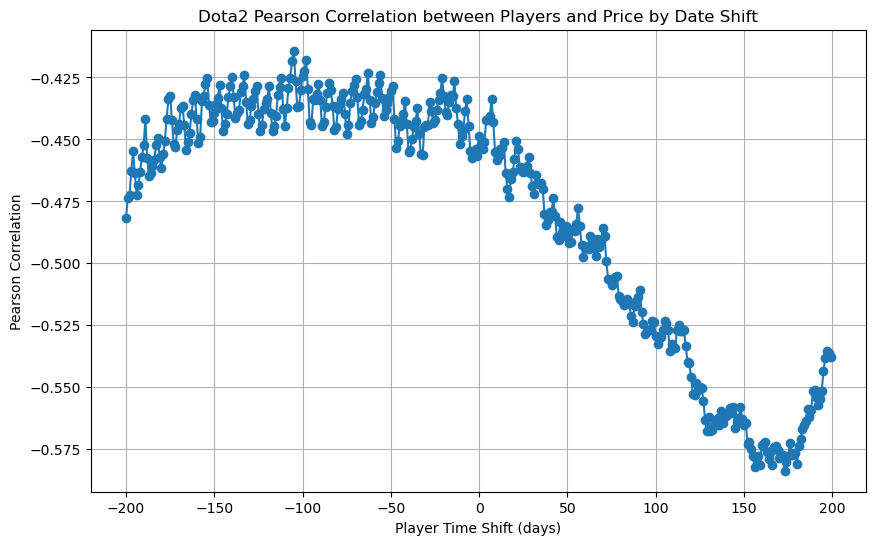

First local maximum to the left: Offset=-105.0, Correlation=-0.41


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json

# Load the JSON price data
with open('dota2_price_history.json', 'r') as f:
    price_data_json = json.load(f)

# Convert JSON data to DataFrame
price_data = pd.DataFrame(price_data_json['prices'], columns=['DateTime', 'Price', 'Players'])
price_data['DateTime'] = pd.to_datetime(price_data['DateTime'], format="%b %d %Y %H: +0")
price_data['Price'] = price_data['Price'].astype(float)
price_data['Players'] = price_data['Players'].astype(int)

# Load the player count data from CSV
player_data = pd.read_csv('dota2_playercount.csv')
player_data['DateTime'] = pd.to_datetime(player_data['DateTime'], errors='coerce')

# Perform time-shifted correlation calculation
correlations = []
for offset in range(-200, 200):
    shifted_player_data = player_data.copy()
    shifted_player_data['DateTime'] = shifted_player_data['DateTime'] - pd.Timedelta(days=offset)

    # Merge on DateTime within 1-day tolerance
    merged_data = pd.merge_asof(
        price_data.sort_values('DateTime'),
        shifted_player_data.sort_values('DateTime'),
        on='DateTime',
        suffixes=('', '_shifted'),
        tolerance=pd.Timedelta('1D'),
        direction='nearest'
    )

    merged_data.dropna(subset=['Players_shifted', 'Price'], inplace=True)

    # Calculate correlation if there are enough data points
    if merged_data.shape[0] < 2:
        continue

    corr, _ = pearsonr(merged_data['Players_shifted'], merged_data['Price'])
    correlations.append((offset, corr))

# Convert correlation results to DataFrame
correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Identify the first local maximum on the left side (negative offsets)
left_side = correlations_df[correlations_df['Offset'] < 0]
local_max_idx = left_side['Correlation'].idxmax()
local_max = correlations_df.iloc[local_max_idx]

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Time Shift (days)')
plt.ylabel('Pearson Correlation')
plt.title('Dota2 Pearson Correlation between Players and Price by Date Shift')
plt.grid(True)

plt.show()

# Print the first local maximum on the left side
print(f"First local maximum to the left: Offset={local_max.Offset}, Correlation={local_max.Correlation:.2f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         6258 non-null   object 
 1   Players          6095 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 146.8+ KB


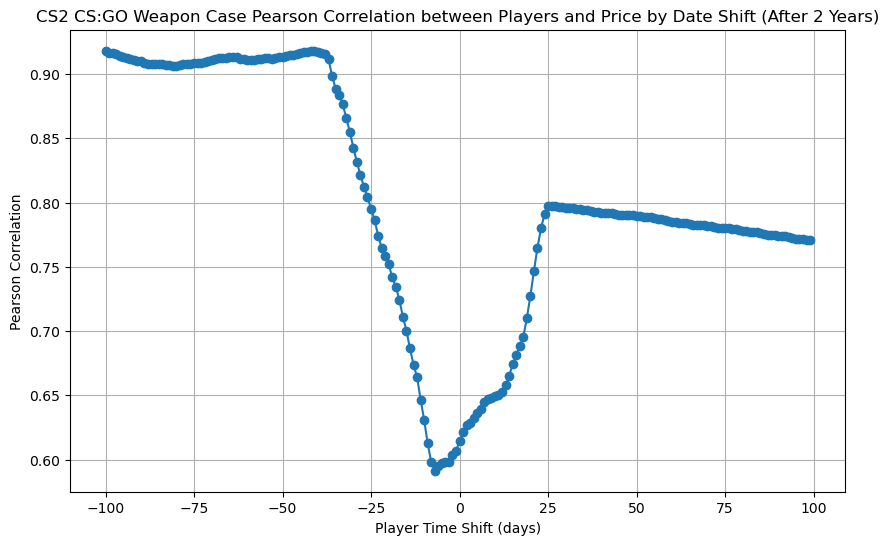

In [ ]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv')

cs_players = pd.read_csv('./PlayerCount/cs2playercount.csv')

cs_players.info()


# Ensure DateTime columns are properly formatted
cs_players['DateTime'] = pd.to_datetime(cs_players['DateTime'], errors='coerce')
cs['DateTime'] = pd.to_datetime(cs['DateTime'], errors='coerce')


# Filter the tf dataset for a specific item
item_name = 'CS:GO Weapon Case'

cs_filtered = cs[cs['Item Name'] == item_name]

start_date = cs_filtered['DateTime'].min() + pd.Timedelta(days=730)
# end_date = start_date + pd.Timedelta(days=365)

# Filter to only the first year of data
# cs_filtered = cs_filtered[(cs_filtered['DateTime'] >= start_date) & (cs_filtered['DateTime'] < end_date)]

cs_filtered = cs_filtered[(cs_filtered['DateTime'] >= start_date)]

# cases = [
#         'CS:GO Weapon Case',
#           'eSports 2013 Case',
#           'Operation Bravo Case',
#           'CS:GO Weapon Case 2',
#           'eSports 2013 Winter Case',
#           'Winter Offensive Case',
#           'CS:GO Weapon Case 3',
#           'Operation Phoenix Case',
#           'Huntsman Weapon Case'
#           'Operation Breakout Weapon Case',
#           'eSports 2014 Summer Case',
#           'Operation Vanguard Case',
#           'Chroma Case',
#           'Chroma 2 Case',
#           'Falchion Case',
#           'Shadow Case',
#           'Revolver Case',
#           'Operation Wildfire Case',
#           'Chroma 3 Case',
#           'Gamma Case',
#           'Gamma 2 Case',
#           'Glove Case',
#           'Spectrum Case',
#           'Operation Hydra Case',
#           'Spectrum 2 Case',
#           'Clutch Case',
#           'Horizon Case',
#           'Danger Zone Case',
#           'Prisma Case',
#           'Shattered Web Case',
#           'CS20 Case',
#           'Prisma 2 Case',
#           'Fracture Case',
#           'Operation Broken Fang Case',
#           'Snakebite Case',
#           'Operation Riptide Case',
#           'Dreams & Nightmares Case',
#           'Recoil Case',
#           'Revolution Case',
#           'Kilowatt Case',
#           'Gallery Case',
#           ]

# cs_filtered = cs[cs['Item Name'].isin(cases)]

# print(tf_filtered)



correlations = []

for offset in range(-100, 100):
    cs_players_offset = cs_players.copy()

    cs_players_offset['DateTime'] = pd.to_datetime(cs_players['DateTime']) - pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_players_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')

    merged_df.dropna(subset=['Players', 'Price'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Players'], merged_df['Price'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Time Shift (days)')
plt.ylabel('Pearson Correlation')
plt.title(f'CS2 {item_name} Pearson Correlation between Players and Price by Date Shift (After 2 Years)')
plt.grid(True)
plt.show()

TF2

(4148, 11)
First local maximum to the left: Offset=-276.0, Correlation=0.60


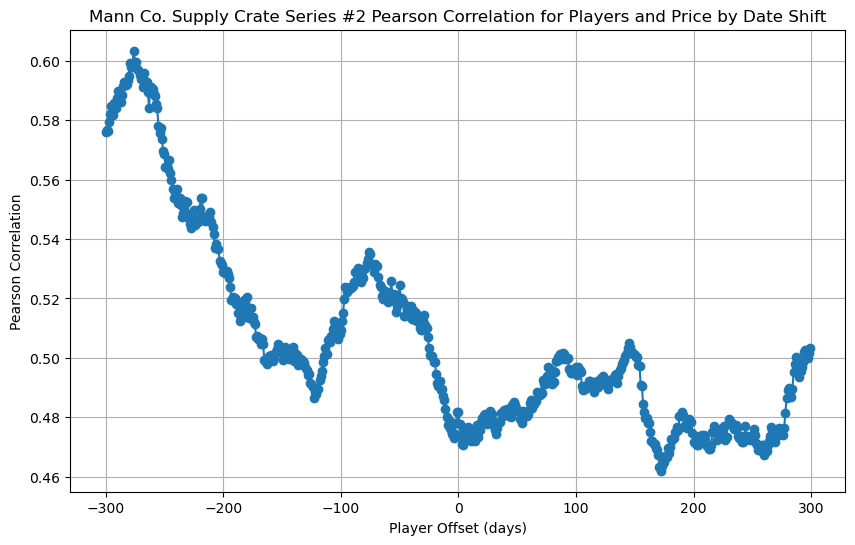

In [50]:
tf_players = pd.read_csv('./PlayerCount/tf2playercount.csv')

# tf_players.info()

tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True)

# Filter the tf dataset for a specific item
item_name = "Mann Co. Supply Crate Series #2"
tf_filtered = tf[tf['Item Name'] == item_name]

print(tf_filtered.shape)

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]


correlations = []

for offset in range(-300, 300):
    tf_players_offset = tf_players.copy()

    tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(tf_filtered.sort_values('DateTime'),
                              tf_players_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=['Players', 'Price'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Players'], merged_df['Price'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Identify the first local maximum on the left side (negative offsets)
left_side = correlations_df[correlations_df['Offset'] < 0]
local_max_idx = left_side['Correlation'].idxmax()
local_max = correlations_df.iloc[local_max_idx]

# Print the first local maximum on the left side
print(f"First local maximum to the left: Offset={local_max.Offset}, Correlation={local_max.Correlation:.2f}")

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title(f'{item_name} Pearson Correlation for Players and Price by Date Shift')
plt.grid(True)
plt.show()

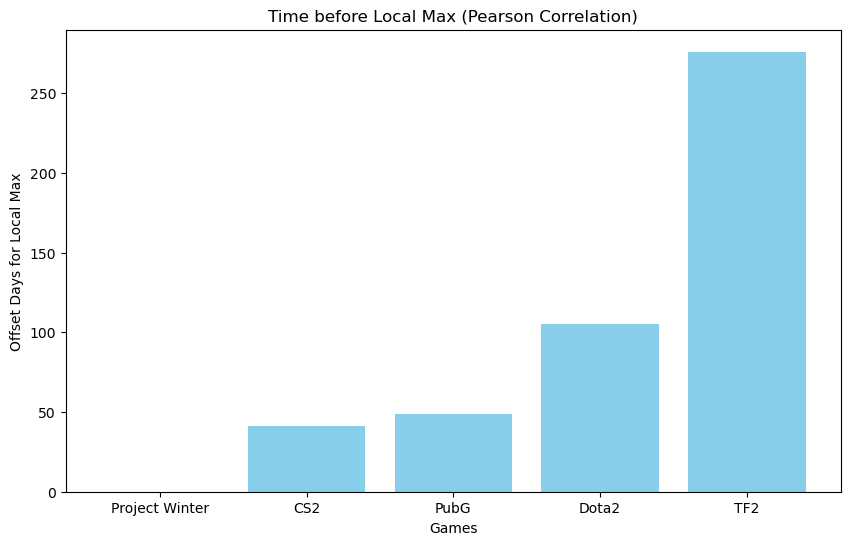

In [52]:
import matplotlib.pyplot as plt

# Data for the bar graph
time_before_local_max = {
    "Project Winter": 0,
    "CS2": 41,
    "PubG": 49,
    "Dota2": 105,
    "TF2": 276,
}

# Extract data for plotting
games = list(time_before_local_max.keys())
offsets = list(time_before_local_max.values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(games, offsets, color='skyblue')

# Add titles and labels
plt.title("Time before Local Max (Pearson Correlation)")
plt.xlabel("Games")
plt.ylabel("Offset Days for Local Max")

# Display the plot
plt.show()

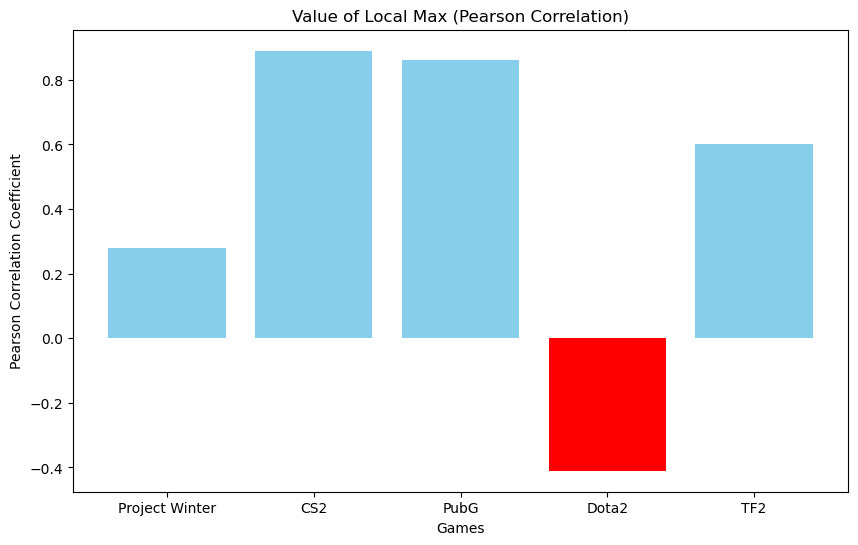

In [54]:
import matplotlib.pyplot as plt

# Data for the bar graph
local_max = {
    "Project Winter": 0.28,
    "CS2": 0.89,
    "PubG": 0.86,
    "Dota2": -0.41,
    "TF2": 0.6,
}

# Extract data for plotting
games = list(local_max.keys())
values = list(local_max.values())

# Set bar colors based on positive or negative values
colors = ['red' if value < 0 else 'skyblue' for value in values]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(games, values, color=colors)

# Add titles and labels
plt.title("Value of Local Max (Pearson Correlation)")
plt.xlabel("Games")
plt.ylabel("Pearson Correlation Coefficient")

# Display the plot
plt.show()

##### 2.4 Game Price (Financial Data)

CS2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DateTime        88 non-null     object 
 1   Final price     88 non-null     float64
 2   Historical low  86 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         6258 non-null   object 
 1   Players          6095 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 146.8+ KB


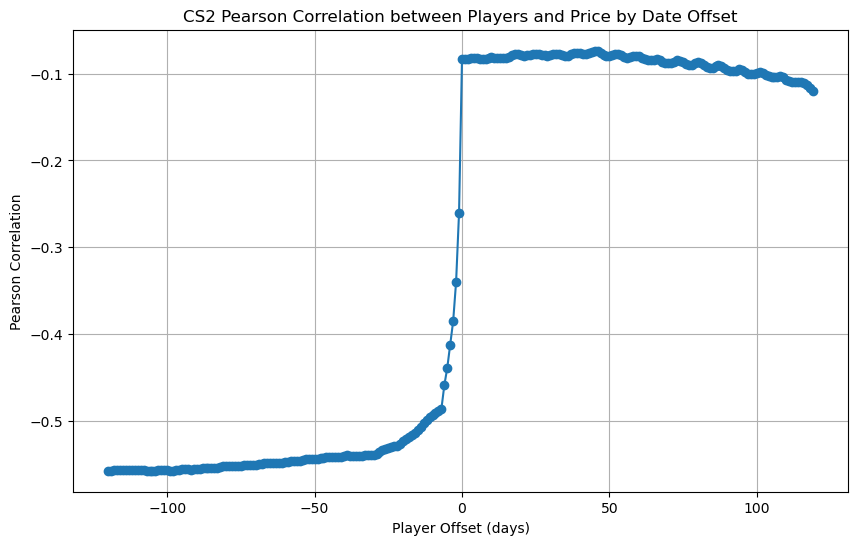

In [ ]:
cs_price = pd.read_csv('./GamePrice/cs2gamepricehistory.csv')

cs_filtered = pd.read_csv('./PlayerCount/cs2playercount.csv')

# cs_filtered = cs[cs['Item Name'].isin(cases)]

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]

cs_price.info()
cs_filtered.info()

# Ensure DateTime columns are properly formatted
cs_price['DateTime'] = pd.to_datetime(cs_price['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')

correlations = []

for offset in range(-120, 120):
    cs_price_offset = cs_price.copy()
    

    cs_price_offset['DateTime'] = pd.to_datetime(cs_price['DateTime']) + pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_price_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('365D'), direction='backward')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=["Final price", 'Players'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Final price'], merged_df['Players'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title('CS2 Pearson Correlation between Players and Price by Date Offset')
plt.grid(True)
plt.show()

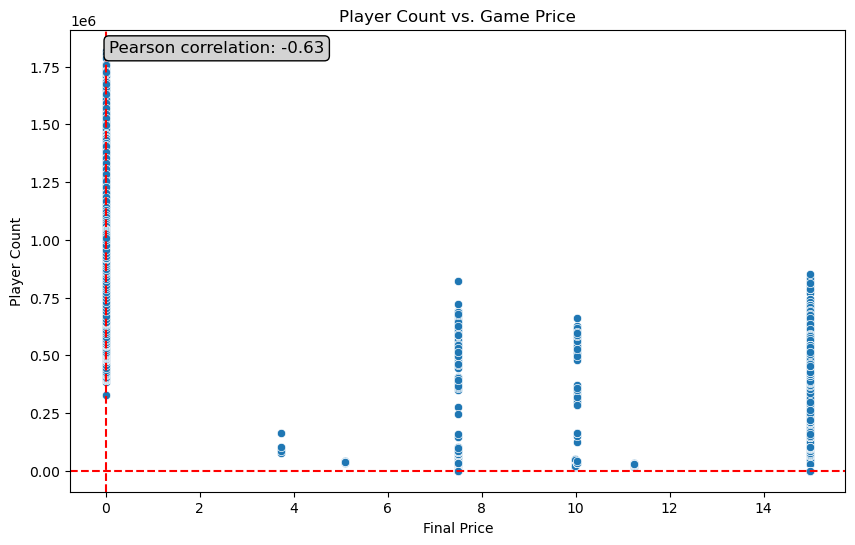

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the game price and player count data
game_prices = pd.read_csv('./GamePrice/cs2gamepricehistory.csv')
cs_players = pd.read_csv('./PlayerCount/cs2playercount.csv')

# Convert DateTime columns to datetime format
game_prices['DateTime'] = pd.to_datetime(game_prices['DateTime'])
cs_players['DateTime'] = pd.to_datetime(cs_players['DateTime'])

# Merge DataFrames
merged_df = pd.merge_asof(
    cs_players.sort_values('DateTime'),
    game_prices.sort_values('DateTime'),
    on='DateTime',
    tolerance=pd.Timedelta('365D'),
    direction='backward'
)

# Replace NaN values in 'Players' with 0 and fill NaN prices
merged_df['Players'].fillna(0, inplace=True)
merged_df['Final price'].fillna(method='ffill', inplace=True)

merged_df.dropna(subset=['Players', "Final price"], inplace=True)

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(merged_df['Players'], merged_df['Final price'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Final price', y='Players')
plt.title('Player Count vs. Game Price')
plt.xlabel('Final Price')
plt.ylabel('Player Count')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.axvline(x=0, color='r', linestyle='--')  # Add a vertical line at x=0

# Annotate the Pearson correlation coefficient
plt.annotate(f'Pearson correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='black', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey'))

plt.show()

TF2

Use Orange Box (TF2 included in bundle)
F2P June 23, 2011

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DateTime       85 non-null     object 
 1   Initial price  85 non-null     float64
 2   Final price    85 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7791 entries, 0 to 7790
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         7791 non-null   object 
 1   Players          7031 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 182.7+ KB


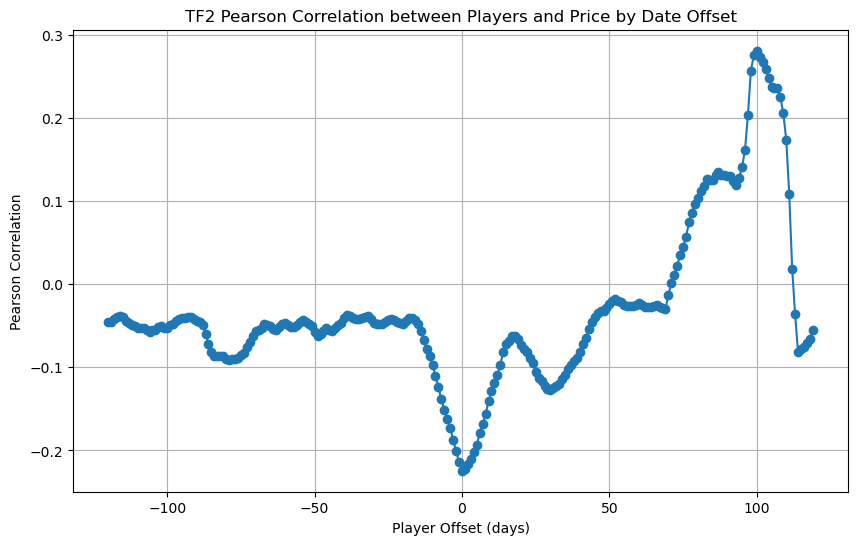

In [ ]:
cs_price = pd.read_csv('./GamePrice/orangeboxgamepricehistory.csv')

cs_filtered = pd.read_csv('./PlayerCount/tf2playercount.csv')

# cs_filtered = cs[cs['Item Name'].isin(cases)]

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]

cs_price.info()
cs_filtered.info()

# Ensure DateTime columns are properly formatted
cs_price['DateTime'] = pd.to_datetime(cs_price['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')

correlations = []

for offset in range(-120, 120):
    cs_price_offset = cs_price.copy()
    

    cs_price_offset['DateTime'] = pd.to_datetime(cs_price['DateTime']) + pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_price_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('365D'), direction='backward')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=["Final price", 'Players'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Final price'], merged_df['Players'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title('TF2 Pearson Correlation between Players and Price by Date Offset')
plt.grid(True)
plt.show()

##### Review Sentiment

CS2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateTime          3457 non-null   object 
 1   Positive reviews  3158 non-null   float64
 2   Negative reviews  3199 non-null   float64
dtypes: float64(2), object(1)
memory usage: 81.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         6258 non-null   object 
 1   Players          6095 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 146.8+ KB


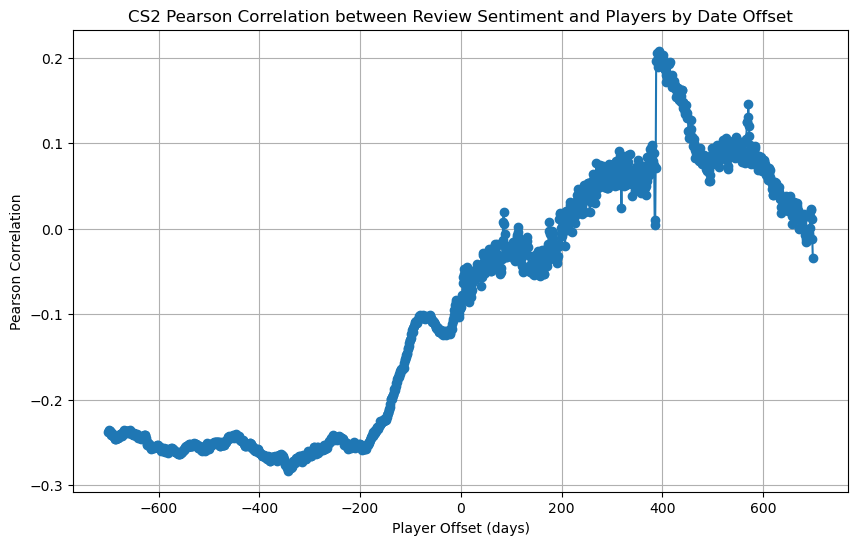

In [ ]:
cs_price = pd.read_csv('./Reviews/csgo_reviews.csv')

cs_filtered = pd.read_csv('./PlayerCount/cs2playercount.csv')

# cs_filtered = cs[cs['Item Name'].isin(cases)]

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]

cs_price.info()
cs_filtered.info()

cs_price['Score'] = cs_price['Positive reviews'] / (cs_price['Positive reviews'] - cs_price['Negative reviews']).where((cs_price['Positive reviews'] - cs_price['Negative reviews']) != 0, 1)

# Ensure DateTime columns are properly formatted
cs_price['DateTime'] = pd.to_datetime(cs_price['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')

correlations = []

for offset in range(-700, 700):
    cs_price_offset = cs_price.copy()
    

    cs_price_offset['DateTime'] = pd.to_datetime(cs_price['DateTime']) + pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_price_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=["Score", 'Players'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Score'], merged_df['Players'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title('CS2 Pearson Correlation between Review Sentiment and Players by Date Offset')
plt.grid(True)
plt.show()

TF2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateTime          3457 non-null   object 
 1   Positive reviews  3122 non-null   float64
 2   Negative reviews  2887 non-null   float64
dtypes: float64(2), object(1)
memory usage: 81.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7791 entries, 0 to 7790
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         7791 non-null   object 
 1   Players          7031 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 182.7+ KB


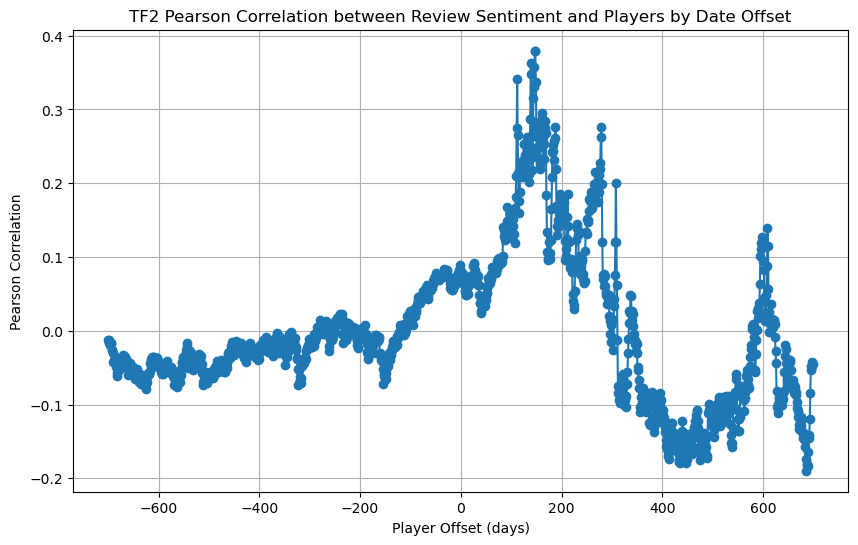

In [ ]:
cs_price = pd.read_csv('./Reviews/tf2_reviews.csv')

cs_filtered = pd.read_csv('./PlayerCount/tf2playercount.csv')

# cs_filtered = cs[cs['Item Name'].isin(cases)]

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]

cs_price.info()
cs_filtered.info()

cs_price['Score'] = cs_price['Positive reviews'] / (cs_price['Positive reviews'] - cs_price['Negative reviews']).where((cs_price['Positive reviews'] - cs_price['Negative reviews']) != 0, 1)

# Ensure DateTime columns are properly formatted
cs_price['DateTime'] = pd.to_datetime(cs_price['DateTime'], errors='coerce')
cs_filtered['DateTime'] = pd.to_datetime(cs_filtered['DateTime'], errors='coerce')

correlations = []

for offset in range(-700, 700):
    cs_price_offset = cs_price.copy()
    

    cs_price_offset['DateTime'] = pd.to_datetime(cs_price['DateTime']) + pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_price_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=["Score", 'Players'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Score'], merged_df['Players'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation')
plt.title('TF2 Pearson Correlation between Review Sentiment and Players by Date Offset')
plt.grid(True)
plt.show()

#### 3. Outlier Detection and Handling

#### 4. Pearson Coefficients and Heatmap

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime          4740 non-null   datetime64[ns]
 1   Price             4740 non-null   float64       
 2   Volume            4740 non-null   float64       
 3   Game Price        4740 non-null   float64       
 4   Historical low    4740 non-null   float64       
 5   Players           4740 non-null   float64       
 6   Average Players   4740 non-null   float64       
 7   Positive reviews  4740 non-null   float64       
 8   Negative reviews  4740 non-null   float64       
 9   Sentiment Score   4740 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 370.4 KB


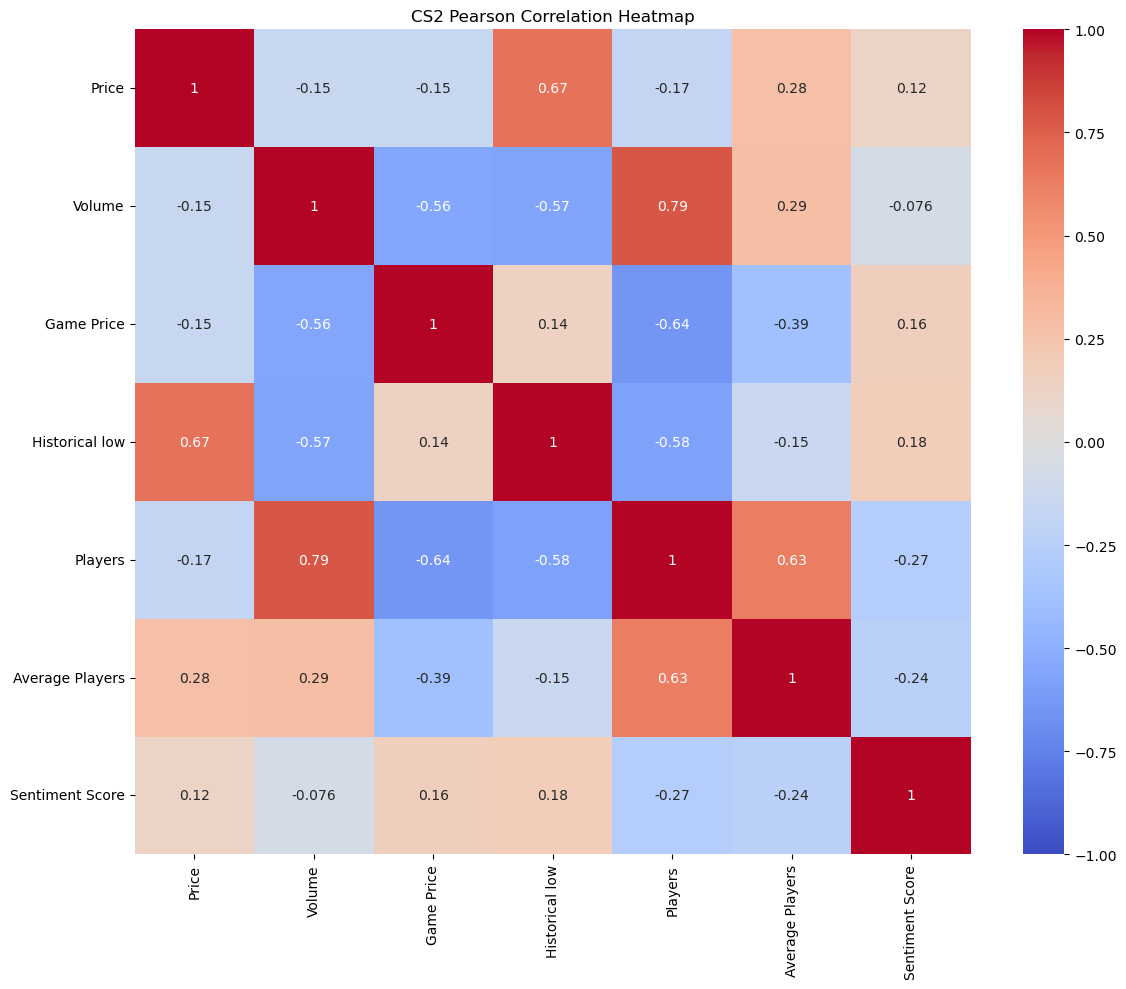

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv')
cs['DateTime'] = pd.to_datetime(cs['DateTime']) + pd.Timedelta(days=25)

price_history = pd.read_csv('./GamePrice/cs2gamepricehistory.csv')
player_count = pd.read_csv('./PlayerCount/cs2playercount.csv')
reviews = pd.read_csv('./Reviews/csgo_reviews.csv')

# Convert DateTime columns to datetime type
cs['DateTime'] = pd.to_datetime(cs['DateTime'])
price_history['DateTime'] = pd.to_datetime(price_history['DateTime'])
player_count['DateTime'] = pd.to_datetime(player_count['DateTime'])
reviews['DateTime'] = pd.to_datetime(reviews['DateTime'])

# Create a date range covering all datasets
start_date = min(cs['DateTime'].min(), price_history['DateTime'].min(), 
                 player_count['DateTime'].min(), reviews['DateTime'].min())
end_date = max(cs['DateTime'].max(), price_history['DateTime'].max(), 
               player_count['DateTime'].max(), reviews['DateTime'].max())
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the full date range
merged_df = pd.DataFrame({'DateTime': date_range})

# Function to merge and fill data
def merge_and_fill(df, right_df, columns):
    df = pd.merge_asof(df.sort_values('DateTime'), 
                       right_df.sort_values('DateTime'), 
                       on='DateTime', 
                       direction='backward')
    for col in columns:
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill').interpolate()
    return df

# Merge datasets
merged_df = merge_and_fill(merged_df, cs.groupby('DateTime').agg({'Price': 'mean', 'Volume': 'sum'}).reset_index(), ['Price', 'Volume'])
merged_df = merge_and_fill(merged_df, price_history, ['Final price', 'Historical low'])
merged_df = merge_and_fill(merged_df, player_count, ['Players', 'Average Players'])
merged_df = merge_and_fill(merged_df, reviews, ['Positive reviews', 'Negative reviews'])

# Calculate sentiment score
merged_df['Sentiment Score'] = merged_df['Positive reviews'] / (merged_df['Positive reviews'] + merged_df['Negative reviews'].abs())

merged_df.rename(columns={'Final price': 'Game Price'}, inplace=True)

merged_df.info()

# Select relevant columns for correlation
columns_for_correlation = ['Price', 'Volume', 'Game Price', 'Historical low', 'Players', 'Average Players', 'Sentiment Score']
correlation_df = merged_df[columns_for_correlation]

# Drop any remaining NaNs before calculating correlation
correlation_df = correlation_df.dropna()

# Calculate Pearson correlation
correlation_matrix = correlation_df.corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('CS2 Pearson Correlation Heatmap')
plt.tight_layout()
plt.show()

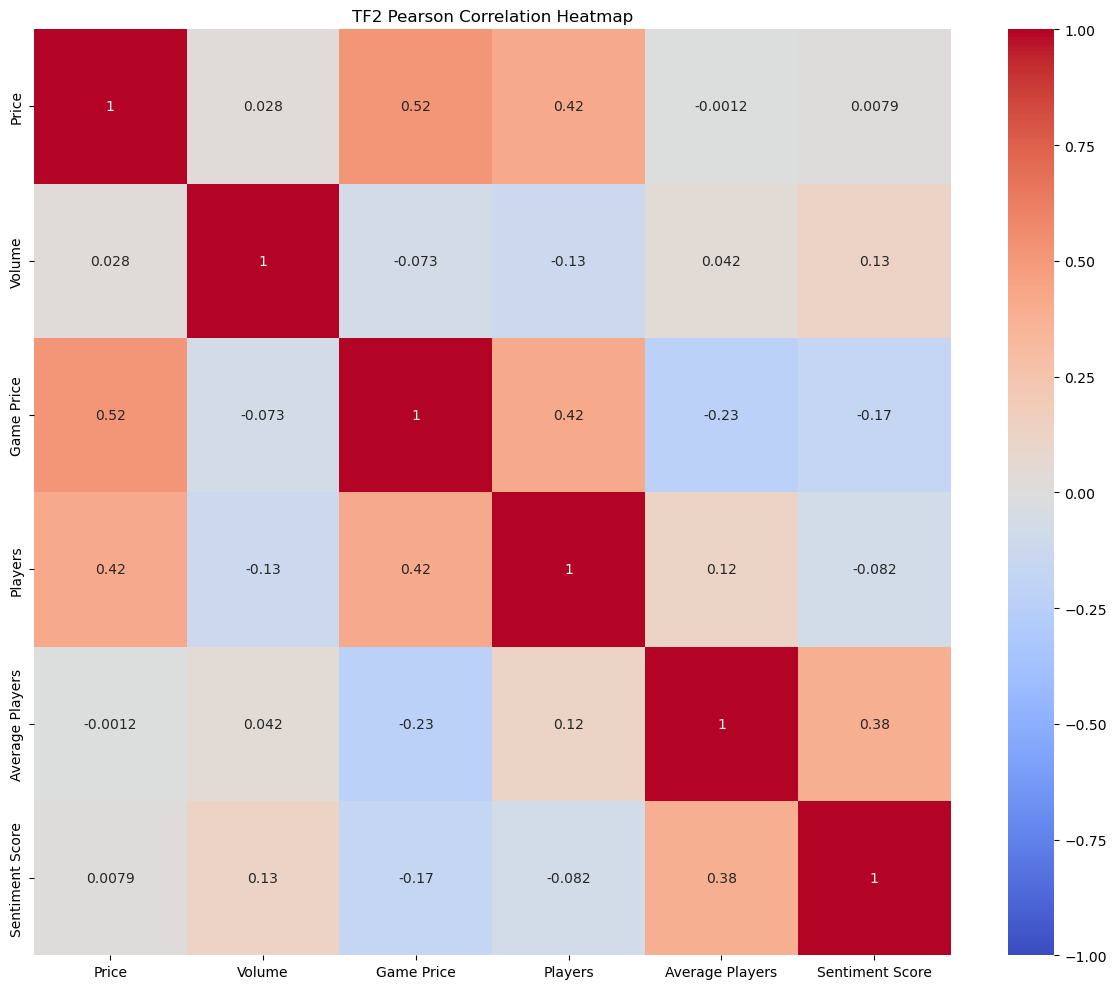

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
cs = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True)
cs['DateTime'] = pd.to_datetime(cs['DateTime']) + pd.Timedelta(days=25)

price_history = pd.read_csv('./GamePrice/orangeboxgamepricehistory.csv')
player_count = pd.read_csv('./PlayerCount/tf2playercount.csv')
reviews = pd.read_csv('./Reviews/tf2_reviews.csv')

# Convert DateTime columns to datetime type
cs['DateTime'] = pd.to_datetime(cs['DateTime'])
price_history['DateTime'] = pd.to_datetime(price_history['DateTime'])
player_count['DateTime'] = pd.to_datetime(player_count['DateTime'])
reviews['DateTime'] = pd.to_datetime(reviews['DateTime'])

# Create a date range covering all datasets
start_date = min(cs['DateTime'].min(), price_history['DateTime'].min(), 
                 player_count['DateTime'].min(), reviews['DateTime'].min())
end_date = max(cs['DateTime'].max(), price_history['DateTime'].max(), 
               player_count['DateTime'].max(), reviews['DateTime'].max())
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the full date range
merged_df = pd.DataFrame({'DateTime': date_range})

# Function to merge and fill data
def merge_and_fill(df, right_df, columns):
    df = pd.merge_asof(df.sort_values('DateTime'), 
                       right_df.sort_values('DateTime'), 
                       on='DateTime', 
                       direction='backward')
    for col in columns:
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill').interpolate()
    return df

# Merge datasets
merged_df = merge_and_fill(merged_df, cs.groupby('DateTime').agg({'Price': 'mean', 'Volume': 'sum'}).reset_index(), ['Price', 'Volume'])
merged_df = merge_and_fill(merged_df, price_history, ['Final price'])
merged_df = merge_and_fill(merged_df, player_count, ['Players', 'Average Players'])
merged_df = merge_and_fill(merged_df, reviews, ['Positive reviews', 'Negative reviews'])

# Calculate sentiment score
merged_df['Sentiment Score'] = merged_df['Positive reviews'] / (merged_df['Positive reviews'] + merged_df['Negative reviews'].abs())

merged_df.rename(columns={'Final price': 'Game Price'}, inplace=True)

# Select relevant columns for correlation
columns_for_correlation = ['Price', 'Volume', 'Game Price', 'Players', 'Average Players', 'Sentiment Score']
correlation_df = merged_df[columns_for_correlation]

# Drop any remaining NaNs before calculating correlation
correlation_df = correlation_df.dropna()

# Calculate Pearson correlation
correlation_matrix = correlation_df.corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('TF2 Pearson Correlation Heatmap')
plt.tight_layout()
plt.show()

#### 5. Machine Learning Algorithms

##### 5.1 Linear Regression